**Цель работы**: выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**План работы**: <a id="plan"></a>
1. [Изучение общей информации о данных](#shag1)
2. [Предобработка данных](#shag2)
3. [Исследовательский анализ данных](#shag3)
4. [Анализ пользователей каждого региона](#shag4)
5. [Проверка гипотез](#shag5)
8. [Общий вывод](#shag6)

In [1]:
import pandas as pd
import numpy as np

import math
from math import sqrt
from scipy import stats as st
from scipy.stats import binom, norm

from sklearn.preprocessing import OrdinalEncoder

import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

import warnings

warnings.filterwarnings("ignore")

<a id="shag1"></a> 
## Изучение общей информации

In [2]:
raw_data = pd.read_csv('/datasets/games.csv')
raw_data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В столбцах *User_score*, *Critic_Score*, *Rating* присутствует большое количество пропусков. 

Параметр *User_score* имеет тип данных *object* вместо *float*

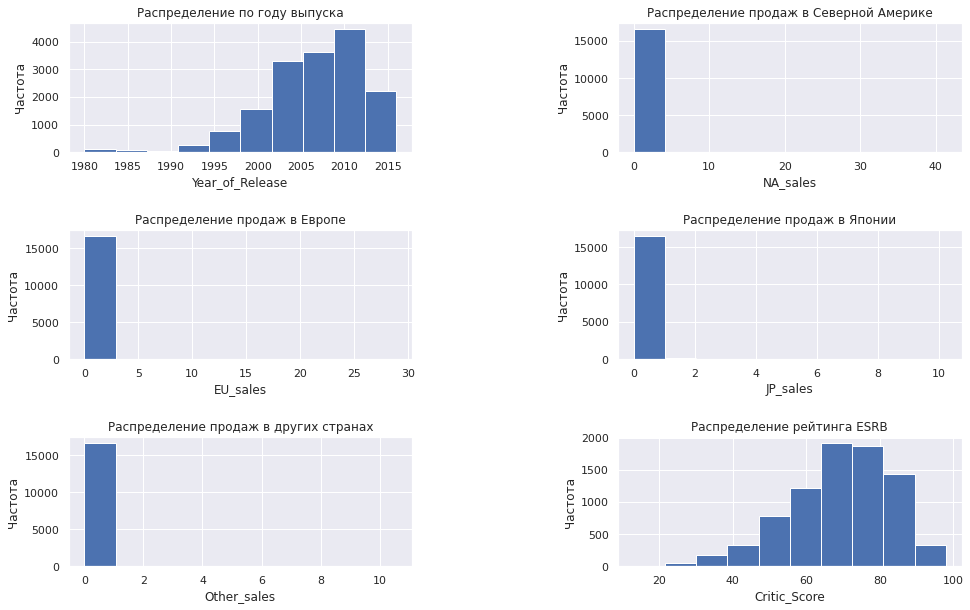

In [4]:
raw_users_hist_titles = ['Распределение по году выпуска',
                         'Распределение продаж в Северной Америке',
                         'Распределение продаж в Европе',
                         'Распределение продаж в Японии',
                         'Распределение продаж в других странах',
                         'Распределение рейтинга ESRB'
                        ]
raw_users_xlabel = ['Year_of_Release', 'NA_sales', 'EU_sales', 'JP_sales', 'Other_sales', 'Critic_Score']
axes = raw_data.hist(figsize=(16, 10)).ravel()
for i in range(len(axes)): 
    axes[i].set_title(raw_users_hist_titles[i])
    axes[i].set_ylabel('Частота')
    axes[i].set_xlabel(raw_users_xlabel[i])
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show();

На графиках можно заметить, что в данных(например, параметрах *NA_sales*, *EU_sales*, *JP_sales*, *Other_sales*) присутствуют выбросы

In [5]:
raw_data.duplicated().sum()

0

**Обзор данных**:
- названия столбцов не соответсвуют стандарту,
- В столбцах *User_sales*, *Critic_Score*, *Rating* присутствуют пропущенные значения,
- параметр *User_score* имеет тип данных object вместо float,
- в столбцах *NA_sales*, *EU_sales*, *JP_sales*, *Other_sales* замечены аномальные значения,
- явные дубликаты в таблице отсутствуют.

<a id="shag2"></a> 
## Предобработка данных

### Приведение названий параметров к корректному виду

In [6]:
raw_data.columns = [col.lower() for col in raw_data.columns]

### Изменение типов данных столбцов

In [7]:
raw_data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В параметре *user_score* встречается значение tbd, из-за чего столбец и имеет тип данных object.

tbd - To Be Determined, то есть "Будет определено". По данному значению не получается определить рейтинг игры, а значит, пока что заменим это значене на NaN

In [8]:
raw_data.loc[raw_data['user_score'] == 'tbd','user_score'] = np.NaN

In [9]:
raw_data['user_score'] = raw_data['user_score'].astype(float)

### Создание отдельного столбца

Создадим отдельный столбец, который будет содержать в себе количество продаж игр по всему миру

In [10]:
raw_data['overall_sales'] = raw_data['na_sales'] + raw_data['eu_sales'] + raw_data['jp_sales'] + raw_data['other_sales']
raw_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,overall_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Обработка пропущенных значений

In [11]:
raw_data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Значение *K-A* впоследствие было переименовано в *E*, так что заменим старые значения на новые
Значение RP означает: "Ожидает рейтинга", а значит и эти данные нужно считать пропусками

In [12]:
raw_data['rating'] = raw_data['rating'].replace({'K-A': 'E', 'RP': 'Unknown'})

In [13]:
raw_data['rating'].fillna('Unknown', inplace=True)

Узнаем, сколько пропусков (в процентном отношении) в каждом столбце

In [14]:
pd.DataFrame(round(raw_data.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
user_score,54.600000
critic_score,51.300000
year_of_release,1.600000
name,0.000000
genre,0.000000
platform,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000


Посмотрим, почему так много пропусков, связанных с оценкой игр

In [15]:
raw_data[raw_data['user_score'].isna() & raw_data['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,overall_sales
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Unknown,40.24
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Unknown,31.38
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,Unknown,30.26
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,Unknown,28.31
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,Unknown,24.67
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,Unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,Unknown,0.01
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,Unknown,0.01


Как видно в таблице, в большинстве игр с пропусками в оценивании игр отсутствуют все 2 значения.

Причиной этому могут быть:
- разная региональная спецификация,
- несоответсвие требованиям оценивания,
- некоторые разработчики могут считать, что их игра не нуждается в оценке.

В параметрах *critic_score*, *user_score* процент пропусков превышает 40%. Восстановление данных в этих столбцах может привести к искажению анализа, а значит от пропущенных значений следует избавиться. Однако, на всякий случай, проверим, как значения в этих столбцах влияют на целевую метрику - *overall_sales* - с помощью тепловой карты.
<a id="heatmap1"></a> 

In [16]:
# в этом датафрейме мы преобразуем категориальные переменные в числовые для того, чтобы понять взаимосвязь параметров
numeric_raw_data = raw_data.copy()
numeric_raw_data.dropna(inplace=True)

In [17]:
# найдём все колонки с категориальными переменными
cat_cols = [col for col in numeric_raw_data.columns if numeric_raw_data[col].dtype == 'object']
cat_cols

['name', 'platform', 'genre', 'rating']

In [18]:
# преобразуем категориальные признаки в числовые значения с помошью OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
numeric_raw_data[cat_cols] = ordinal_encoder.fit_transform(numeric_raw_data[cat_cols])

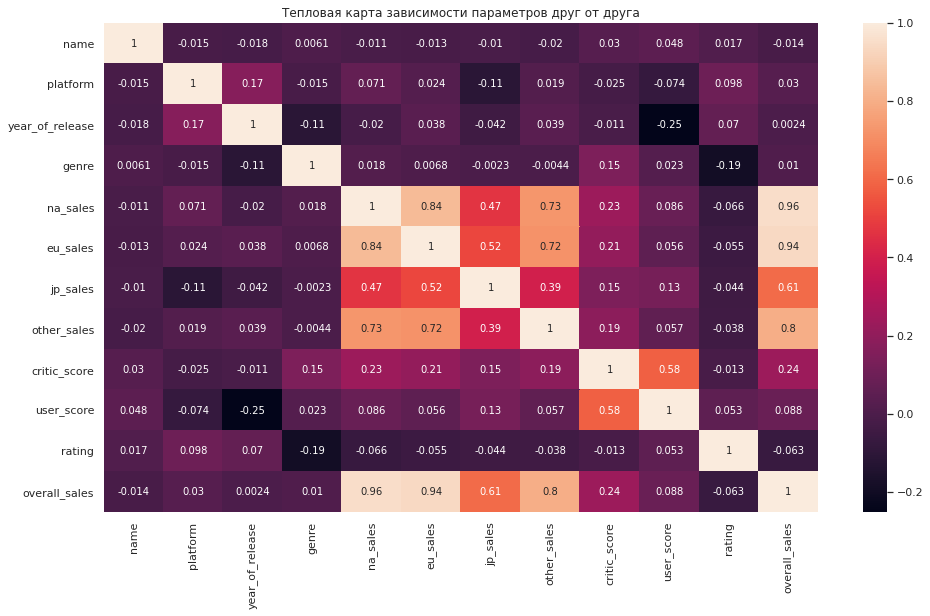

In [19]:
plt.figure(figsize=(16, 9))
sns.heatmap(numeric_raw_data.corr(), annot=True)
plt.title('Тепловая карта зависимости параметров друг от друга')
plt.show();

In [20]:
# можно ли считать эту таблиуц показательной для всего исследования? просто тогда выводы в конце исследования будут некорректными

На графике видно, что на общие продажи параметры  *user_score* практически  не влияет, а значит от этого столбца, в котром огромное количество пропущенных значений, можно избавиться.

В то же время параметр *critic_score*:
- довольно сильно влияет на итоговые продажи, а значит, от него не следует избавляться,
- имеет более 50% пропусков, а значит, восстановление данных может привести к искажению исследования.

Создадим две таблицы: неимеющую параметры *user_score* и *critic_score* и соддержащую данные столбцы(таких данных будет меньше)

In [21]:
research_data = raw_data.dropna()
data = raw_data.drop(columns=['user_score', 'critic_score'], axis=1)

In [22]:
data.isna().sum().sort_values(ascending=False)

year_of_release    269
name                 2
genre                2
platform             0
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
rating               0
overall_sales        0
dtype: int64

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   rating           16715 non-null  object 
 9   overall_sales    16715 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.3+ MB


В параметрах year_of_release, name, genre слишком мало пропусков для того, чтобы их обрабатывать, кроме того, эти значения восстановить не получится, так что просто удалим строки с пропущенными данными.

In [24]:
data.dropna(inplace=True)

In [25]:
data.isna().sum().sort_values(ascending=False)

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
rating             0
overall_sales      0
dtype: int64

В данных не осталось пропущенных значений

### Поиск неявных дубликатов

In [26]:
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [27]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [28]:
sorted(data['name'].unique())

[' Beyblade Burst',
 ' Fire Emblem Fates',
 " Frozen: Olaf's Quest",
 ' Haikyu!! Cross Team Match!',
 ' Tales of Xillia 2',
 "'98 Koshien",
 '.hack//G.U. Vol.1//Rebirth',
 '.hack//G.U. Vol.2//Reminisce',
 '.hack//G.U. Vol.2//Reminisce (jp sales)',
 '.hack//G.U. Vol.3//Redemption',
 '.hack//Infection Part 1',
 '.hack//Link',
 '.hack//Mutation Part 2',
 '.hack//Outbreak Part 3',
 '.hack//Quarantine Part 4: The Final Chapter',
 '.hack: Sekai no Mukou ni + Versus',
 '007 Racing',
 '007: Quantum of Solace',
 '007: The World is not Enough',
 '007: Tomorrow Never Dies',
 '1 vs. 100',
 '1/2 Summer +',
 '10 Minute Solution',
 '100 All-Time Favorites',
 '100 Classic Books',
 '100 Classic Games',
 '1000 Cooking Recipes from ELLE à table',
 '1001 Touch Games',
 '101-in-1 Explosive Megamix',
 '101-in-1 Party Megamix Wii',
 '101-in-1 Sports Megamix',
 '101-in-1 Sports Party Megamix',
 '1080°: TenEighty Snowboarding',
 '11eyes: CrossOver',
 '12-Sai. Honto no Kimochi',
 '12-Sai. Koisuru Diary',
 '12Ri

In [29]:
set([i[0] for i in data['name']] + [i[-1] for i in data['name']])

{' ',
 '!',
 '#',
 '$',
 '%',
 "'",
 ')',
 '+',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '~',
 '¡',
 'Ø',
 'α',
 '\u200b',
 '♪'}

В данных были обнаружены неявные дублилкаты, которые характеризуются наличием таких знаков, как: 

 '~',
 '¡',
 'Ø',
 'α',
 '\u200b',
 '♪'
 '[',
 ']',
 ' ',
 '!',
 '#',
 '$',
 '%',
 "'",
 ')',
 '+',
 '-',
 '.',
 '?',
 
в начале или конце названия игры.

Поменяем названия игр на корректные

In [30]:
# список некорректных символов
bad_list = ['~', '¡', 'Ø', 'α', '\u200b', '♪', '[', ']', ' ', '!', '#', '$', '%', "'", ')', '+', '-', '.', '?']
# функция изменения названий игр
def correct_name(df):
    name = df['name']
    
    if name[0] in bad_list:
        name = name[1:]
    if name[-1] in bad_list:
        name = name[:-1]
    
    return name

In [31]:
for i in range(10):
    data['name'] = data.apply(correct_name, axis=1)
    research_data['name'] = research_data.apply(correct_name, axis=1)    

In [32]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [33]:
sorted(data['year_of_release'].unique())

[1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0]

In [34]:
data = data[data[['name', 'platform','year_of_release']].duplicated(keep=False) == False]

Дубликатов не осталось

In [35]:
# Код ревьюера
data[data[['name', 'platform','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,rating,overall_sales


**В результате предобработки данных были:**

- изменены названия столбцов(на более корректные),
- изменён тип данных столбца *user_score* c object на float,
- изменено значение рейтинга *K-A* на *E*,
- пропущенные значения рейтинга были заменены на *Unknown*,
- создан столбец *overall_sales*, который показывает общий объём продаж,
- cоздана таблица **data**, где были удалены столбцы *rating*, *user_score* , *ctitic_score* из-за слишком большого количества пропусков,а также удалены некоторые(менее 2%) данные, которые нельзя было восстановить,
- cоздана таблица **research_data** для будущей проверки гипотез, где остались все метрики, а также были удалены все недостающие значения
- удалены неявные дубликаты

<a id="shag3"></a> 
## Исследовательский анализ данных

In [36]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,rating,overall_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,E,82.54
1,Super Mario Bros,NES,1985.0,Platform,29.08,3.58,6.81,0.77,Unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,Unknown,31.38


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16442 entries, 0 to 16714
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16442 non-null  object 
 1   platform         16442 non-null  object 
 2   year_of_release  16442 non-null  float64
 3   genre            16442 non-null  object 
 4   na_sales         16442 non-null  float64
 5   eu_sales         16442 non-null  float64
 6   jp_sales         16442 non-null  float64
 7   other_sales      16442 non-null  float64
 8   rating           16442 non-null  object 
 9   overall_sales    16442 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.4+ MB


### Поиск нужного временного отрезка

В разные годы выпускалось разное количество игр. Сократим исследуемый промежуток, выбрав только те года, когда было продано много игр

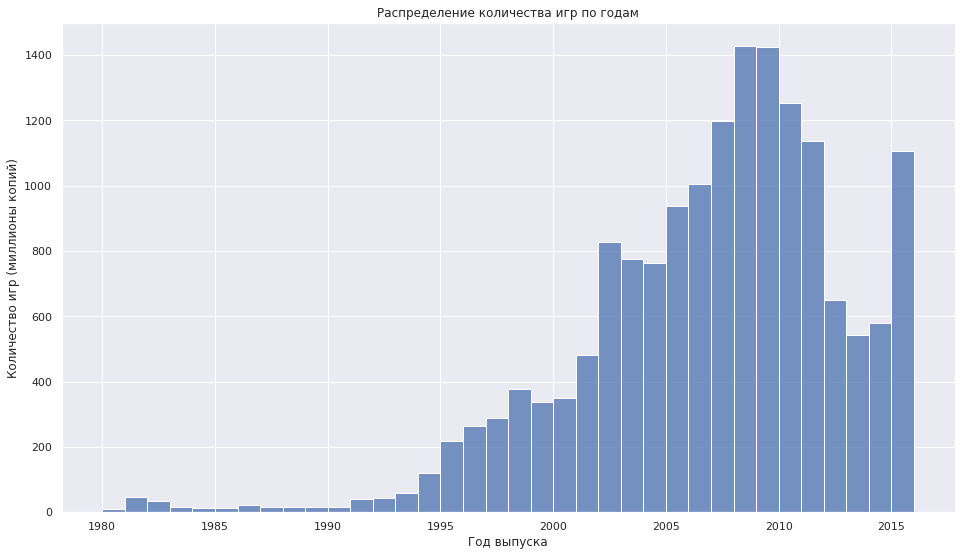

In [38]:
plt.figure(figsize=(16,9))

sns.histplot(data['year_of_release'], bins=36)

plt.title('Распределение количества игр по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр (миллионы копий)')
plt.show();

На графике видно, что большинство игр выпускалось с 1995 года, поэтому возьмём промежуток "1995-2016" года

In [39]:
data2 = data[data['year_of_release'] >= 1995]

### Поиск актуального периода для анализа данных

In [40]:
# таблица, содержащая количество игр, выпущенных на разных платформах
platforms_count = (
    data2
    .groupby(['platform'])
    ['overall_sales']
    .sum()
    .sort_values(ascending=False)
    .iloc[:15]
)
platforms_count.head()

platform
PS2     1233.56
X360     961.24
PS3      928.77
Wii      891.18
DS       802.76
Name: overall_sales, dtype: float64

Будем считать платформы популярными, если общие продажи игр на них превышают 200 миллионов.<a id="plt_per_year"></a> 

In [41]:
popular_platforms = platforms_count[platforms_count > 200].index

Построим графики распределения продаж игр на популярных платформах

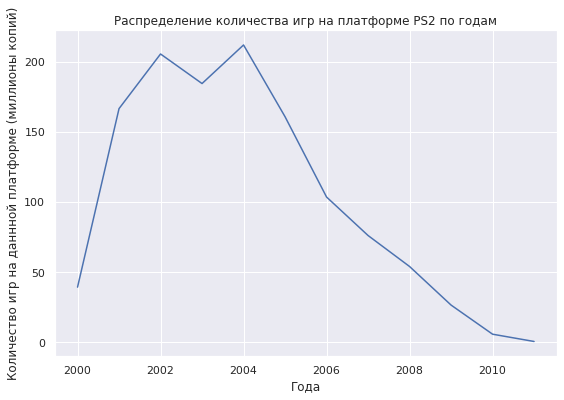

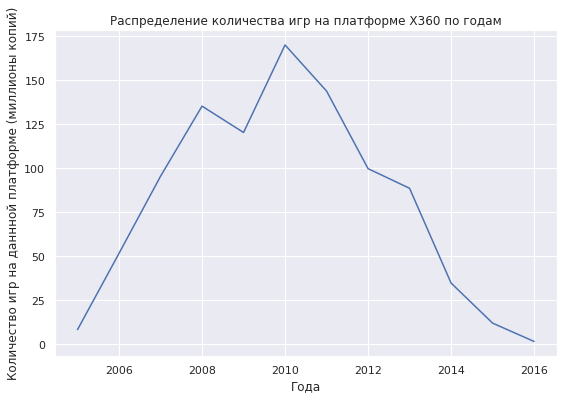

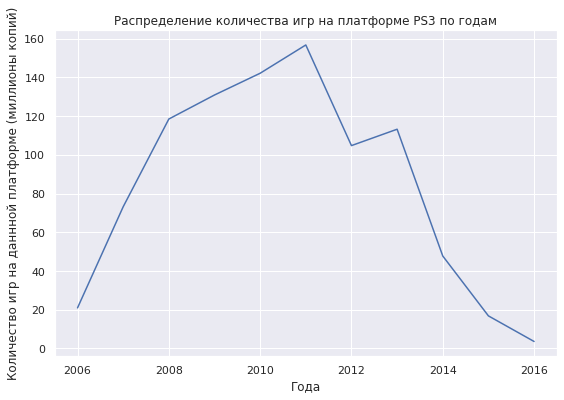

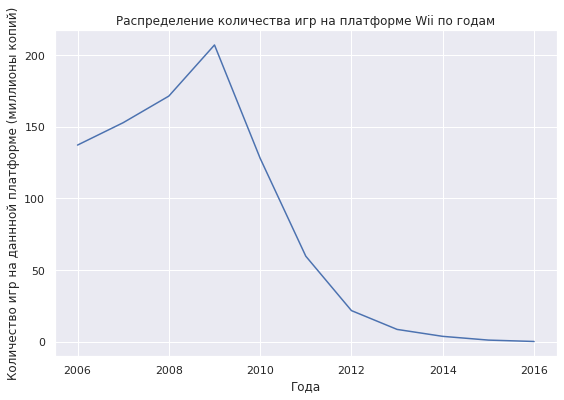

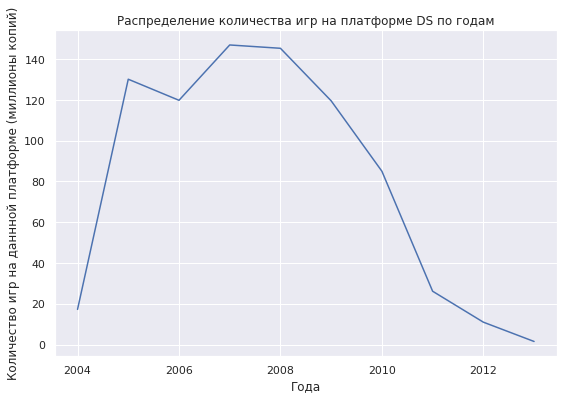

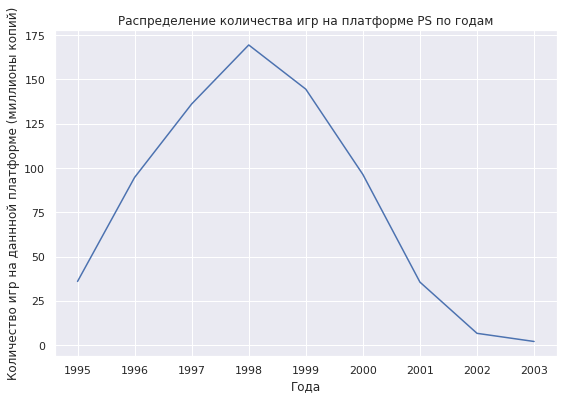

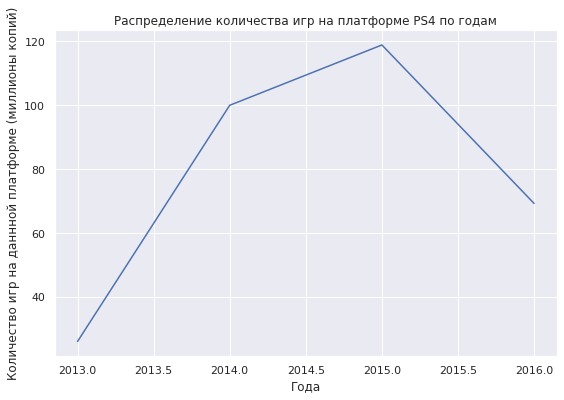

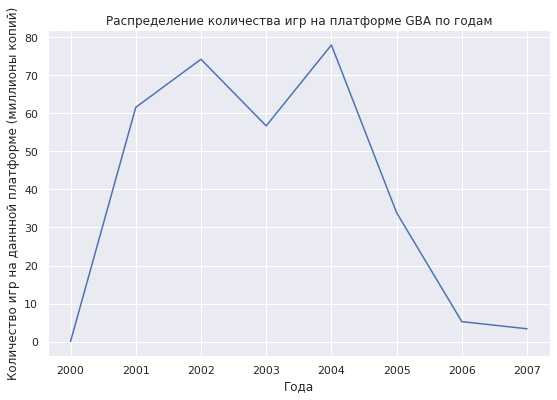

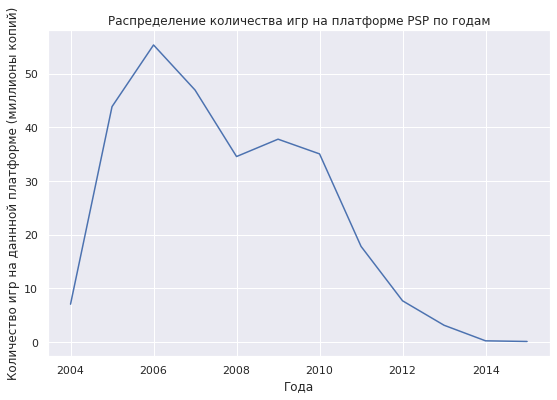

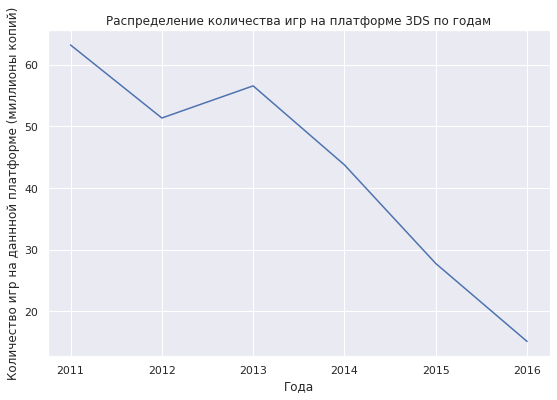

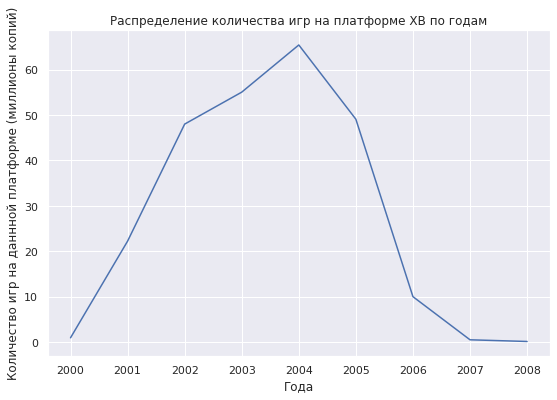

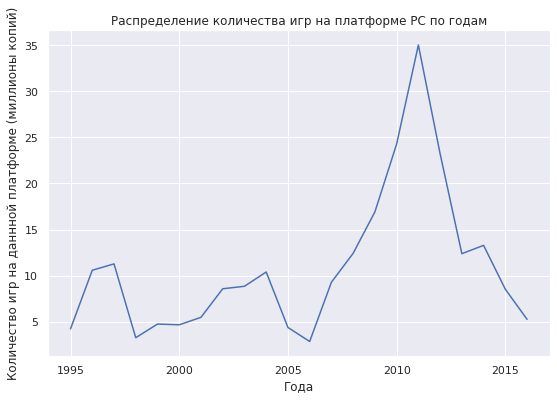

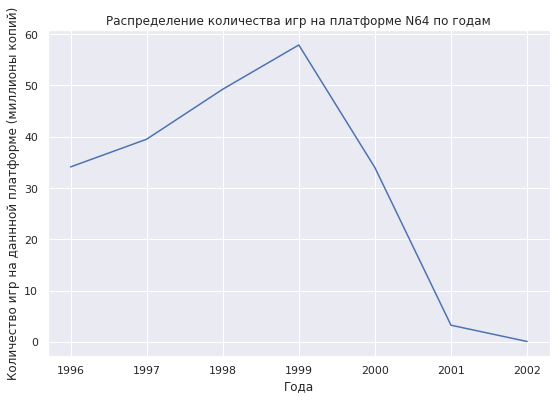

In [42]:
for col in popular_platforms:
    plt.figure(figsize=(9,6))
    platform_data = data2[data2['platform'] == col].groupby('year_of_release')['overall_sales'].sum()
    ax = platform_data.plot(x=platform_data.index, y=platform_data)
    ax.set_title(f'Распределение количества игр на платформе {col} по годам')
    ax.set_xlabel('Года')
    ax.set_ylabel('Количество игр на даннной платформе (миллионы копий)')
    plt.show();

На графиках видно, что среднее время популярности игровых платформ варьируется от 6 до 8 лет

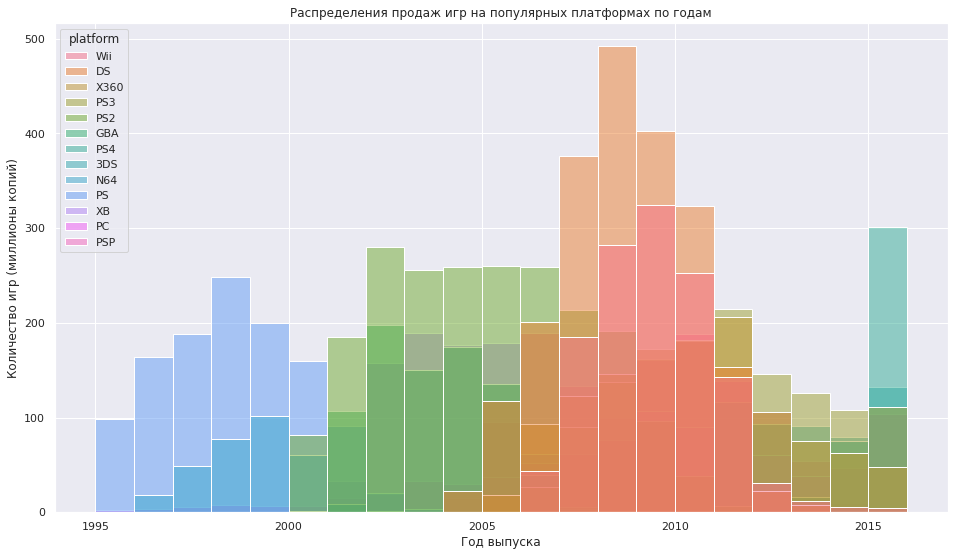

In [43]:
plt.figure(figsize=(16,9))

sns.histplot(data=data2[data2['platform'].isin(popular_platforms)], x='year_of_release', hue='platform', bins=21)

plt.title('Распределения продаж игр на популярных платформах по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр (миллионы копий)')
plt.show();

Составим таблицу, которая будет показывать, когда платформу использовали в первый и последний раз

In [44]:
# функция, которая возращает сумму последних продаж платформы
def last_sale(row):
    plt = row['platform']
    year = row['last_release']
    sales = data2[(data2['year_of_release'] == year) & (data2['platform'] == plt)]['overall_sales'].sum()
    return sales

In [45]:
first_platform_release = pd.DataFrame(
    data2
    .sort_values('year_of_release')
    .groupby('platform')
    .agg({'year_of_release': 'first'})
)

last_platform_release = pd.DataFrame(
    data2
    .sort_values('year_of_release')
    .groupby('platform')
    .agg({'year_of_release': 'last'})
    .reset_index()
)

platform_release = (
    first_platform_release
    .merge(last_platform_release, on='platform')
    .rename(columns={'year_of_release_x': 'first_release', 'year_of_release_y': 'last_release'})
    .sort_values('first_release')
)

platform_release['last_sales'] = platform_release.apply(last_sale, axis=1)

platform_release['years_of_popularity'] = platform_release['last_release'] - platform_release['first_release']
platform_release

,platform,first_release,last_release,last_sales,years_of_popularity
0,3DO,1995.0,1995.0,0.08,0.0
19,TG16,1995.0,1995.0,0.16,0.0
4,GB,1995.0,2001.0,9.24,6.0
18,SNES,1995.0,1999.0,0.26,4.0
17,SAT,1995.0,1999.0,0.09,4.0
8,NG,1995.0,1996.0,0.10,1.0
9,PC,1995.0,2016.0,5.25,21.0
11,PS,1995.0,2003.0,2.07,8.0
7,N64,1996.0,2002.0,0.08,6.0
10,PCFX,1996.0,1996.0,0.03,0.0


In [46]:
platform_release['years_of_popularity'].describe()

count    26.000000
mean      6.346154
std       4.664267
min       0.000000
25%       3.250000
50%       6.000000
75%       9.750000
max      21.000000
Name: years_of_popularity, dtype: float64

В ходе анализа времени популярности различных игровых платформ было выявлено, что средний срок популярности платформ составляет 6.35 лет. 

Таким образом, чтобы игра возымела успех, что нам следует учитывать только те игровые станции, чья популярность до сих пор не пропала и не планирует падать в 2017 году.

Найдём период времени, который будет актуален для построения прогноза на 2017 год

In [47]:
actual_platforms_data = platform_release[platform_release['last_release'] == 2016].sort_values('first_release')
actual_platforms = actual_platforms_data['platform']
actual_platforms_data

,platform,first_release,last_release,last_sales,years_of_popularity
9,PC,1995.0,2016.0,5.25,21.0
23,X360,2005.0,2016.0,1.52,11.0
13,PS3,2006.0,2016.0,3.60,10.0
21,Wii,2006.0,2016.0,0.18,10.0
16,PSV,2011.0,2016.0,4.25,5.0
1,3DS,2011.0,2016.0,15.14,5.0
22,WiiU,2012.0,2016.0,4.60,4.0
14,PS4,2013.0,2016.0,69.25,3.0
25,XOne,2013.0,2016.0,26.15,3.0


По таблице видно, что период актуальных платформ - **"2013 - 2016"** года, так как платформы, выпущенные в 2013 году до сих пор показывают хорошие продажи(в отличии от более старых платформ).

Кроме того, c помощью данных из этой таблицы и [графиков распределения количества игр на платформах по годам](#plt_per_year), можно выделить несколько платформ,

которые лидируют по продажам:
- XOne
- PS4
- 3DS

которые имеют убывающие объёмы продаж:
- Wii
- X360
- PS3

<a id="period_conclusion"></a> 
Потенциально прибыльные платформы: PS4, XOne, 3DS

In [48]:
data3 = data2[data2['year_of_release'] >= 2013]
research_data = research_data[research_data['year_of_release'] >= 2013]

### Изучение распределения продаж каждой платформы

Для этого воспользуемся графиком "ящик с усами"

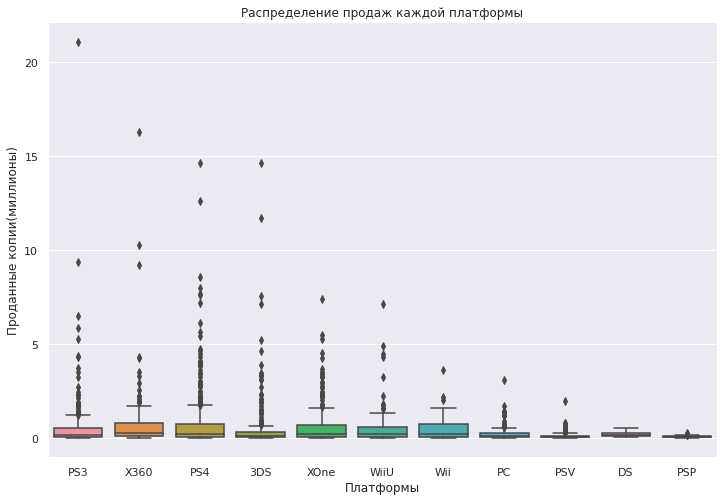

In [49]:
plt.figure(figsize=(12, 8))

sns.boxplot(data=data3, x='platform', y='overall_sales')

plt.title('Распределение продаж каждой платформы')
plt.ylabel('Проданные копии(миллионы)')
plt.xlabel('Платформы')
plt.show();

Более подробные графики:

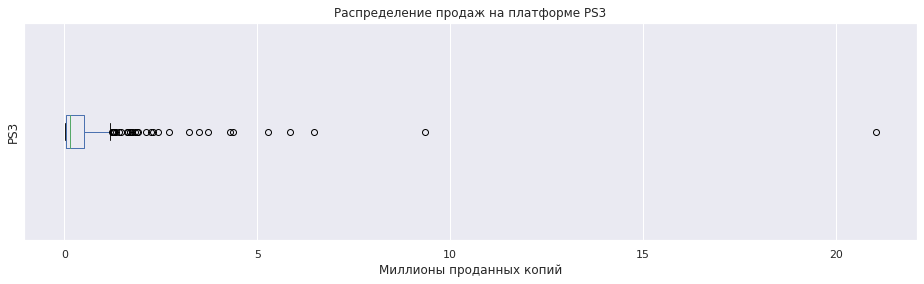

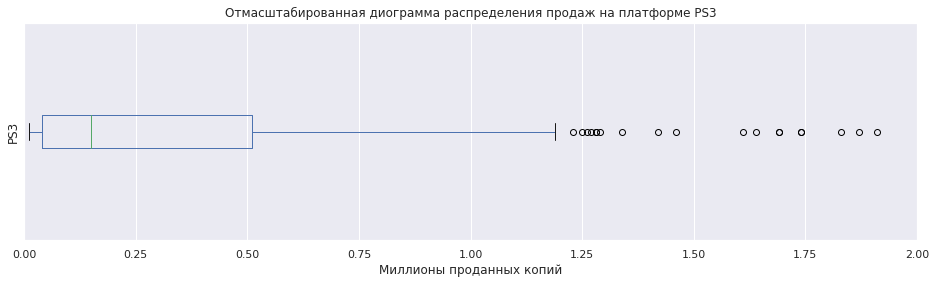

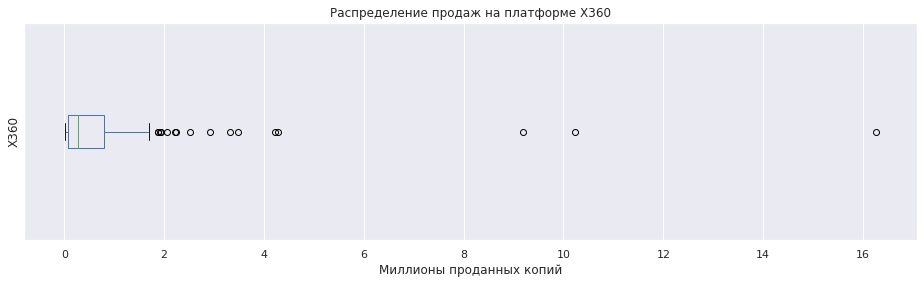

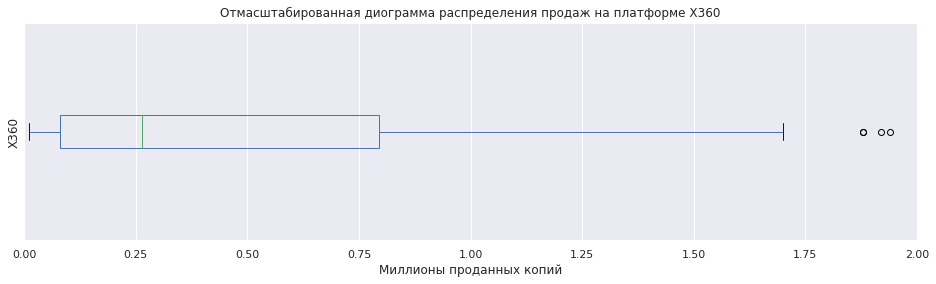

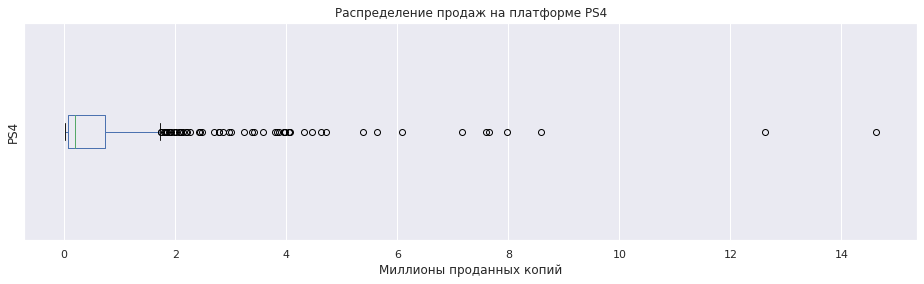

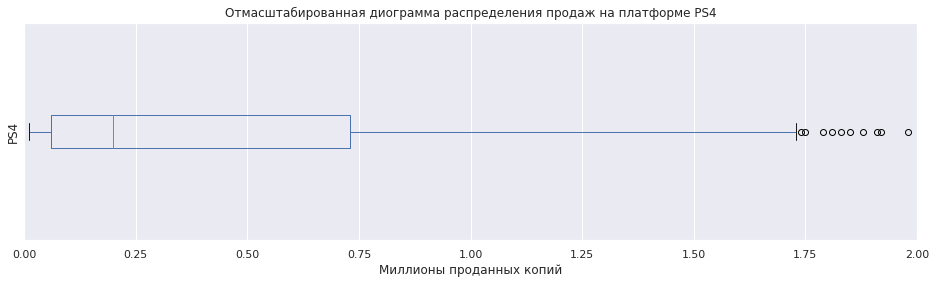

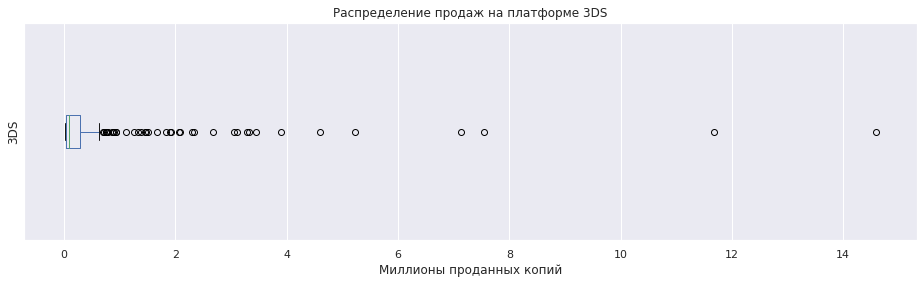

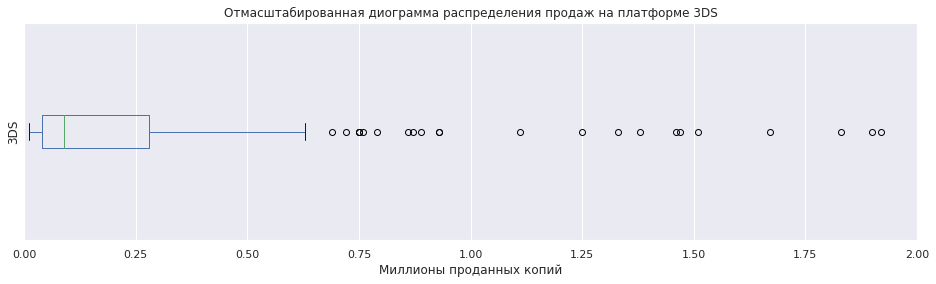

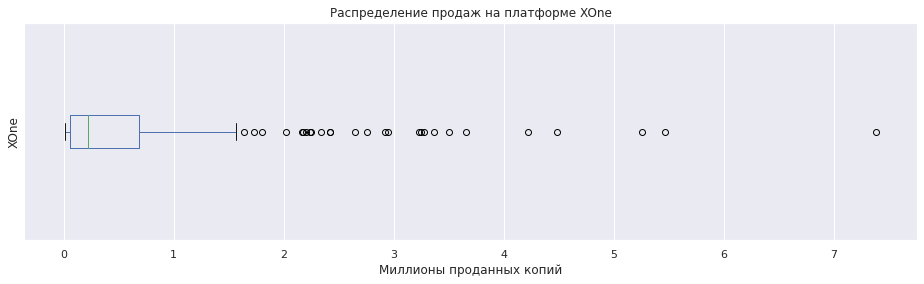

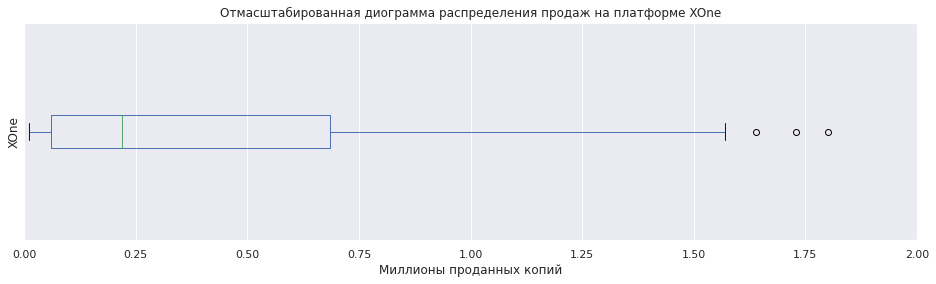

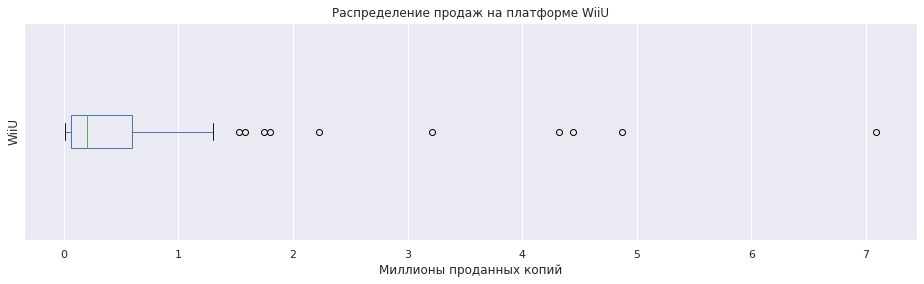

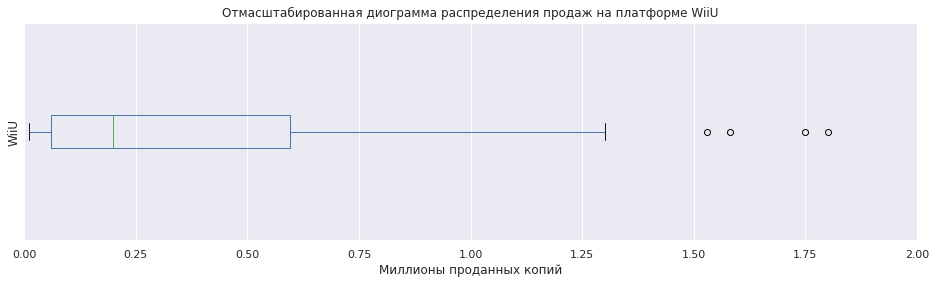

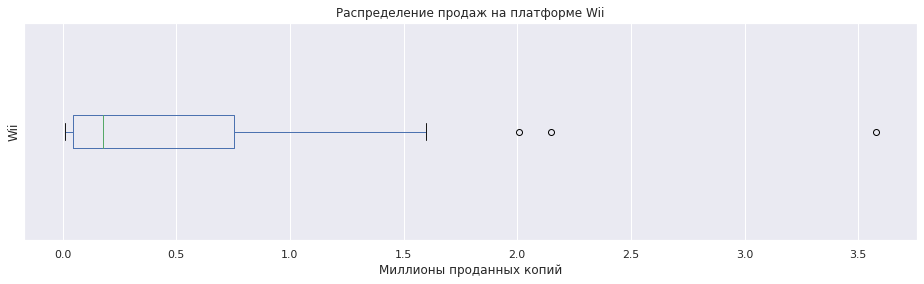

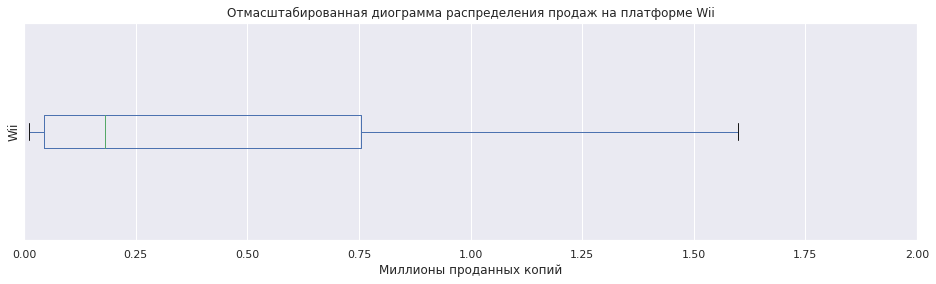

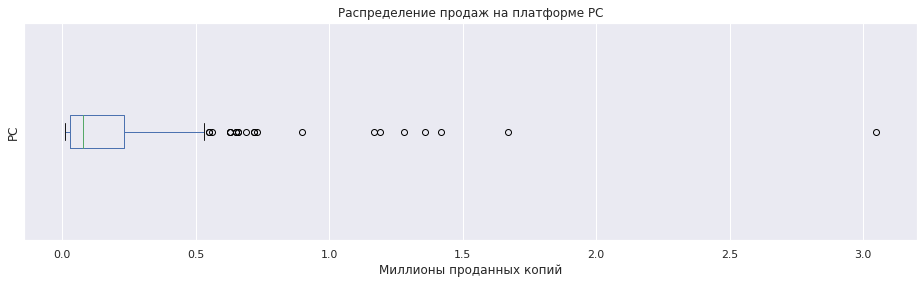

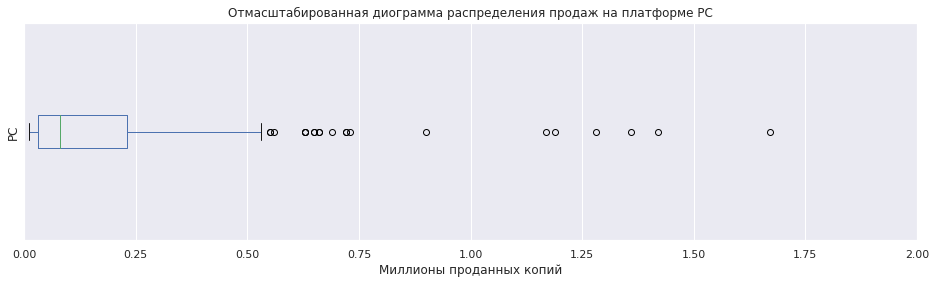

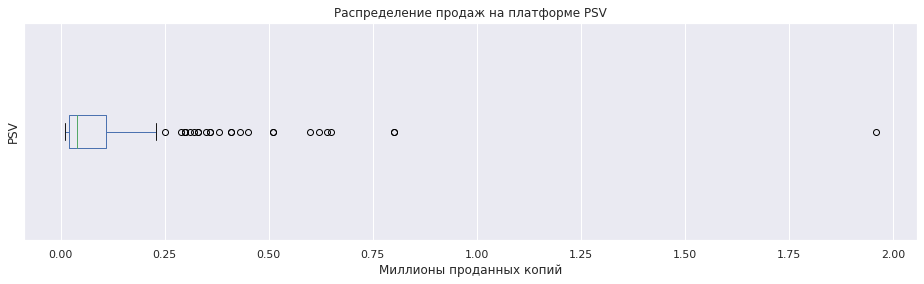

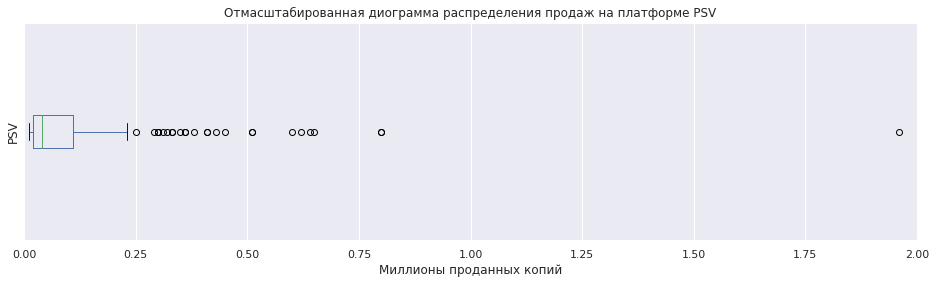

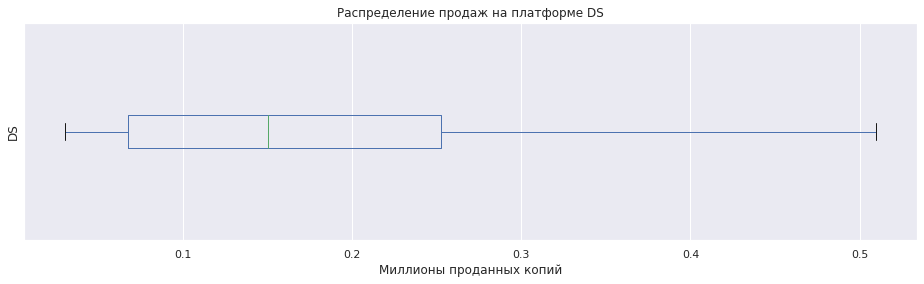

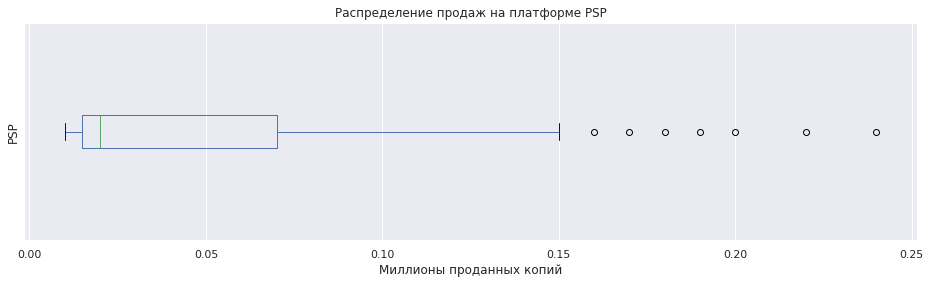

In [50]:
for platform in data3['platform'].unique():
    
    plt.figure(figsize=(16,4))
    platform_data = data3[data3['platform'] == platform]['overall_sales']
    ax = platform_data.plot(x=platform_data, kind='box', vert=False)
    plt.yticks([])
    plt.xlabel('Миллионы проданных копий')
    plt.ylabel(platform)
    plt.title(f"Распределение продаж на платформе {platform}")
    
    if platform not in ['PSP', 'DS']:
        plt.figure(figsize=(16,4))
        ax = platform_data.plot(x=platform_data, kind='box', vert=False, xlim=(0, 2))
        plt.yticks([])
        plt.xlabel('Миллионы проданных копий')
        plt.ylabel(platform)
        plt.title(f"Отмасштабированная диограмма распределения продаж на платформе {platform}")
    plt.show();

Что можно сказать, взглянув на эти графики:

- можно заметить чёткое деление популярности платформ на 2 группы:

    1) популярные(макс. количество проданных копий > 5)
    
    2) непопулярные (макс. количество проданных копий < 5)
    
    
- практически у каждой платформы есть "выстрелившая" игра(ы), продажи которой значительно превосходят другие,

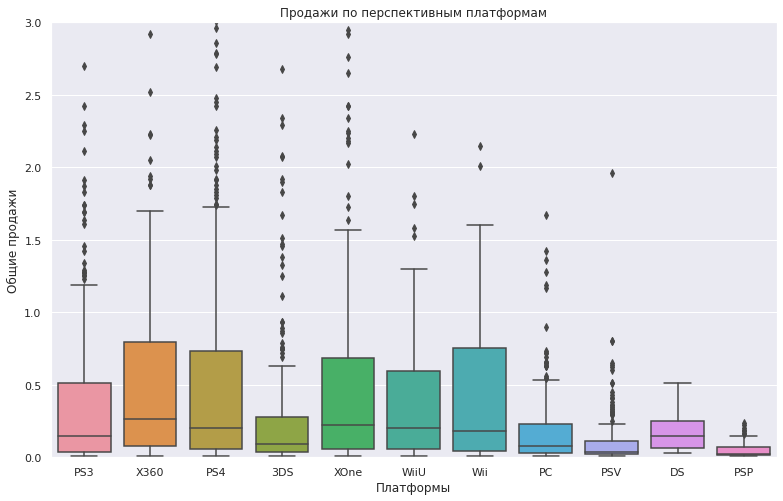

In [70]:
# Код ревьюера

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(13, 8))
sns.boxplot(data=data3, y='overall_sales', x='platform')

plt.title('Продажи по перспективным платформам')
plt.xlabel('Платформы')
plt.ylabel('Общие продажи')
plt.ylim(0, 3)

plt.show()

### Анализ влияния отзывов на продажи 

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков

В качестве популярной платформы выберем PS2, так как на этой станции было выпущено больше всего игр

In [51]:
ps2_data = raw_data[raw_data['platform'] == 'PS2']

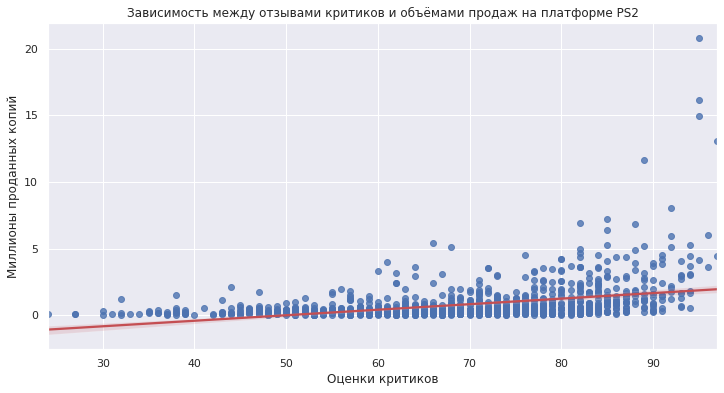

Корреляция: 0.3954345494545487


In [52]:
plt.figure(figsize=(12, 6))

sns.regplot(data=ps2_data, x='critic_score', y='overall_sales',  line_kws=dict(color="r"))

plt.title('Зависимость между отзывами критиков и объёмами продаж на платформe PS2')
plt.xlabel('Оценки критиков')
plt.ylabel('Миллионы проданных копий')
plt.show();

print('Корреляция:', ps2_data['overall_sales'].corr(ps2_data['critic_score']))

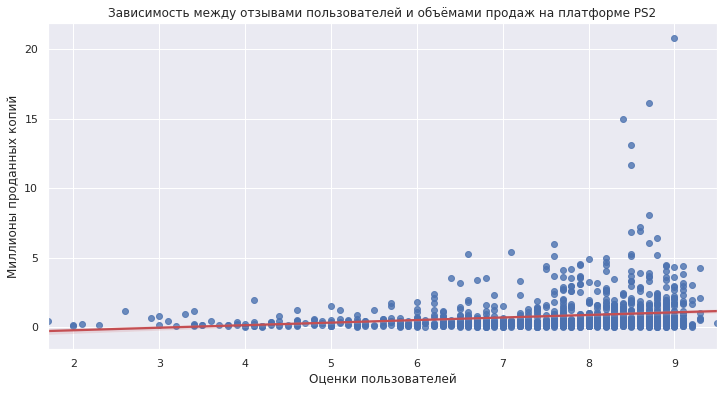

Корреляция: 0.17286551112058224


In [53]:
plt.figure(figsize=(12, 6))

sns.regplot(data=ps2_data, x='user_score', y='overall_sales',  line_kws=dict(color="r"))

plt.title('Зависимость между отзывами пользователей и объёмами продаж на платформe PS2')
plt.xlabel('Оценки пользователей')
plt.ylabel('Миллионы проданных копий')
plt.show();

print('Корреляция:', ps2_data['overall_sales'].corr(ps2_data['user_score']))

Получается, что на объёмы продаж оценка критиков(корреляция ~ 0.4) влияет слабо, в то время как отзывы пользователей практически не коррелируют с количеством проданных копий(~ 0.17)

Однако мы рассматривали только данные самой популярной платформы(PS2). Посмотрим, как объёмы продаж игр на других платформах зависит от оценок критиков и пользователей.

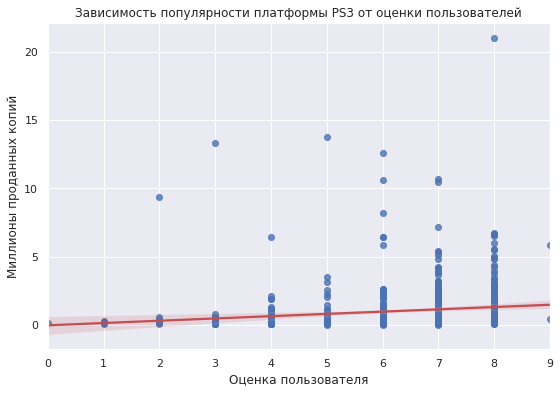

Корреляция: 0.14001350599151016


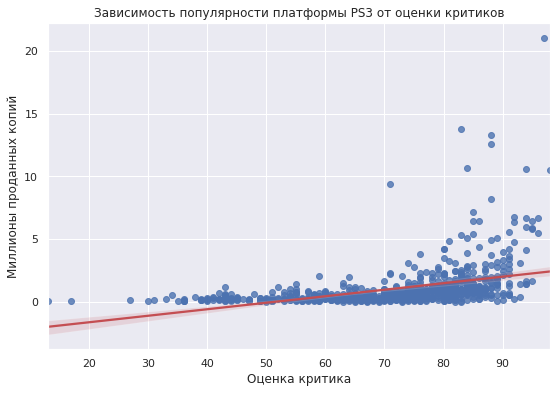

Корреляция: 0.4282129041298839


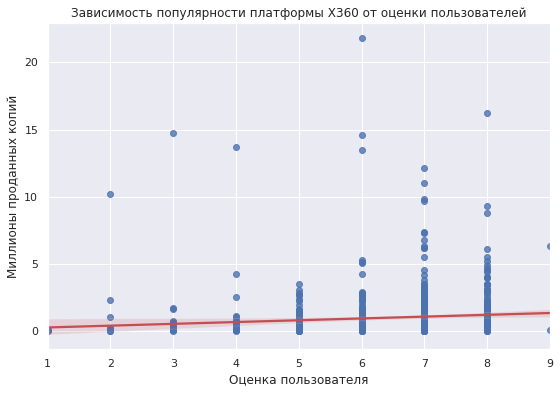

Корреляция: 0.10007903292720738


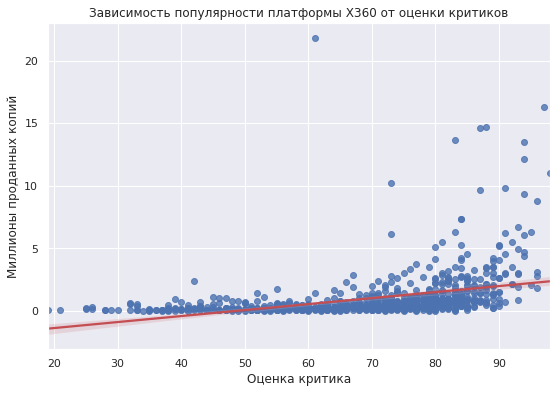

Корреляция: 0.3889921155786245


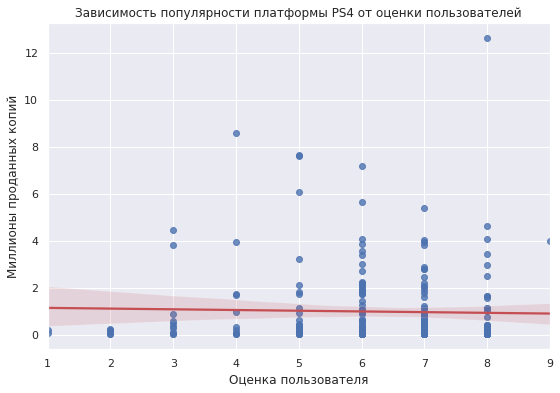

Корреляция: -0.0271621501540288


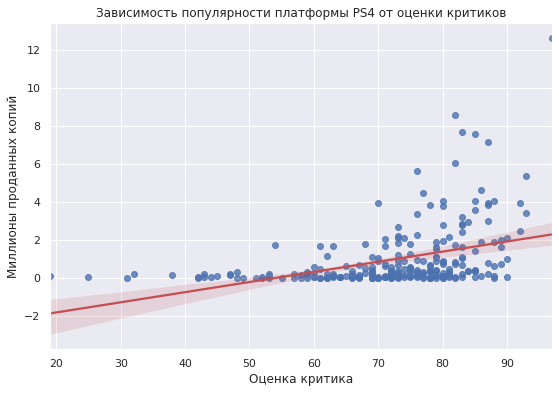

Корреляция: 0.40589480145836687


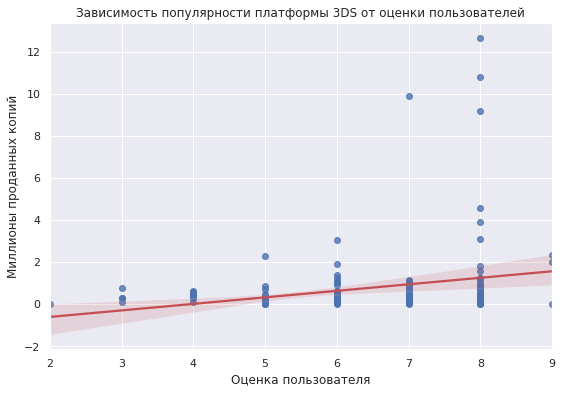

Корреляция: 0.23861831209673479


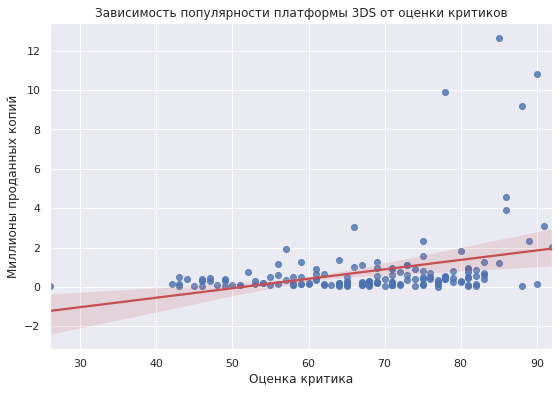

Корреляция: 0.3389038644633216


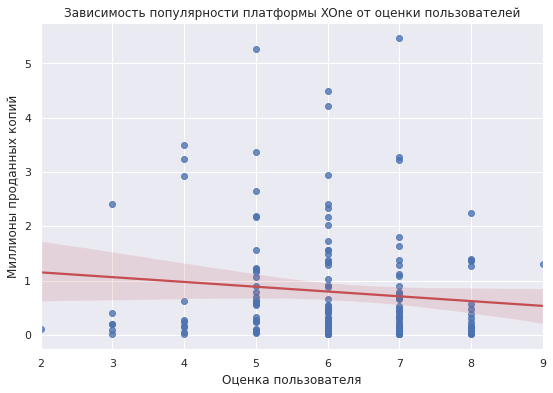

Корреляция: -0.11176896375215047


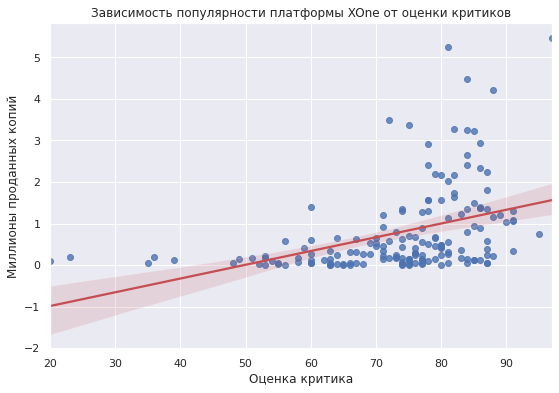

Корреляция: 0.4104220356129637


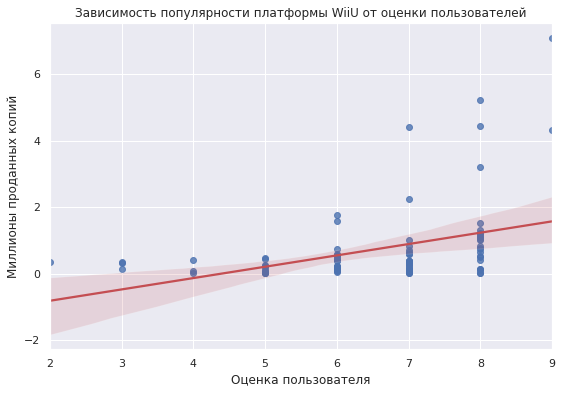

Корреляция: 0.39479996817586416


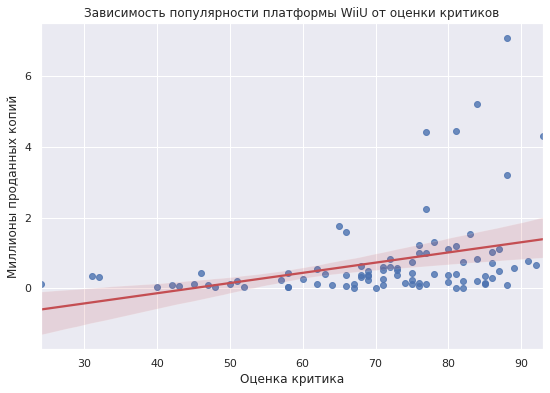

Корреляция: 0.35088242248864304


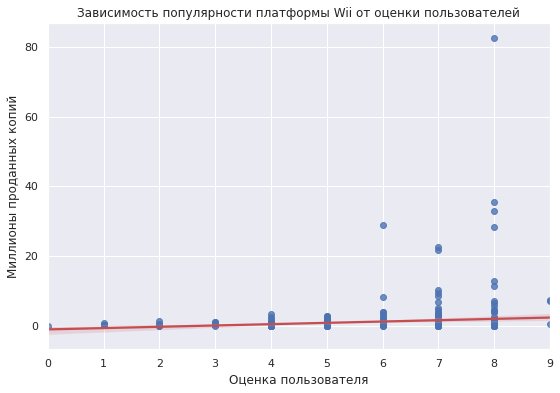

Корреляция: 0.11924222112448768


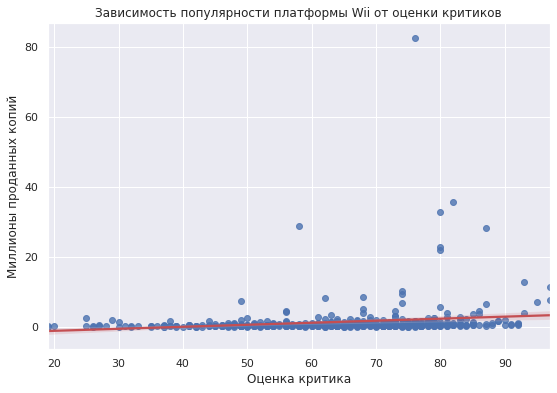

Корреляция: 0.17085459105550813


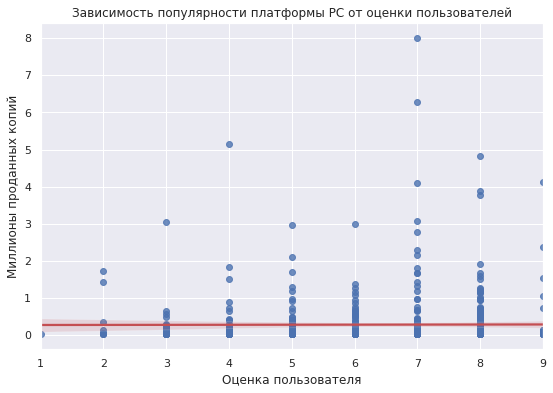

Корреляция: 0.0039989668649156335


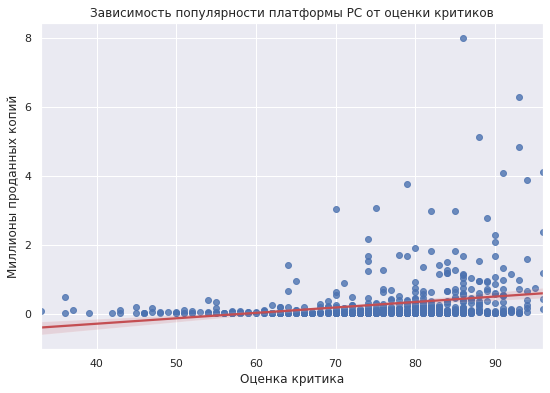

Корреляция: 0.257260981042733


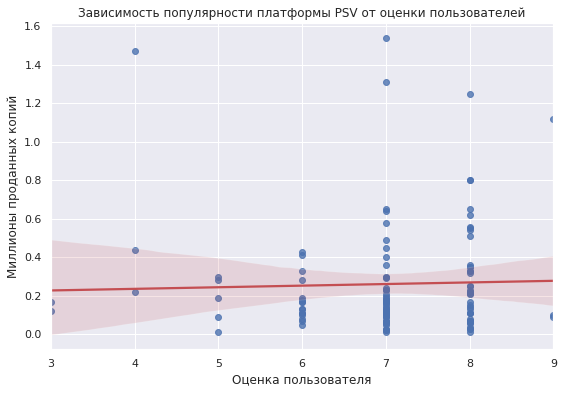

Корреляция: 0.032482697585745186


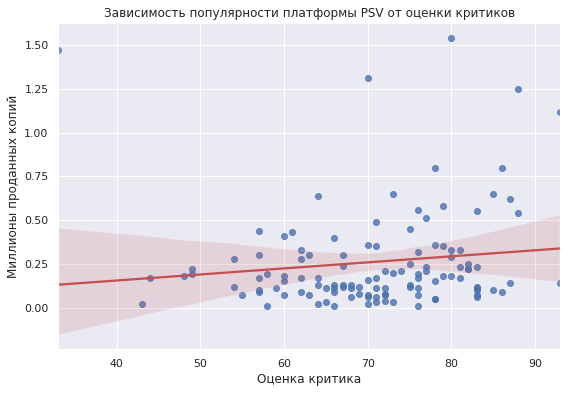

Корреляция: 0.13161921121004785


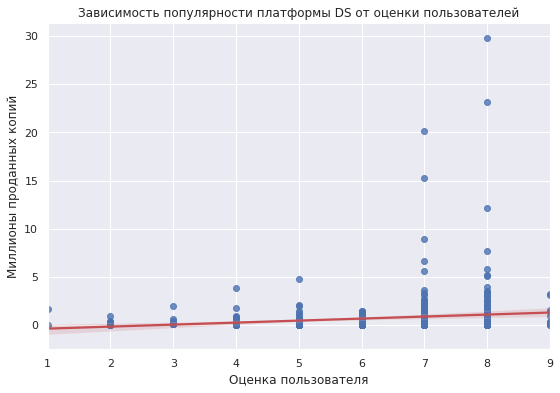

Корреляция: 0.12879520016041476


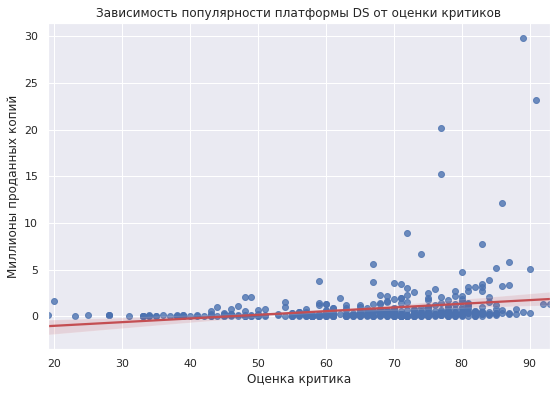

Корреляция: 0.23225806699643337


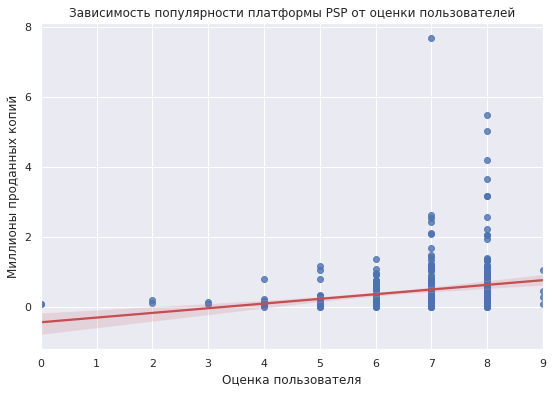

Корреляция: 0.2107346338455469


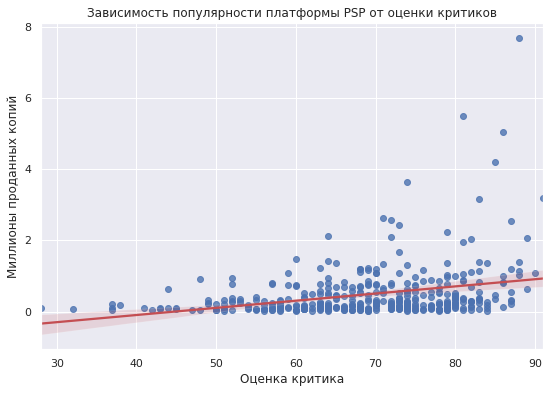

Корреляция: 0.2997168362225047


In [54]:
for platform in [p for p in data3['platform'].unique() if p != 'PS2']:
    _data = (
        raw_data
        [(raw_data['platform'] == platform) & (raw_data['user_score'] != 'TD')]
        .dropna()
    )
    _data['user_score'] = _data['user_score'].astype(int) 

    if _data.shape[0] > 2:
        for score in ['user_score', 'critic_score']:
            plt.figure(figsize=(9, 6))
            sns.regplot(data=_data, x=score, y='overall_sales',  line_kws=dict(color="r"))
            if score == 'user_score':
                plt.xlabel('Оценка пользователя')
                plt.title(f'Зависимость популярности платформы {platform} от оценки пользователей')
            else:
                plt.xlabel('Оценка критика')
                plt.title(f'Зависимость популярности платформы {platform} от оценки критиков')
            plt.ylabel('Миллионы проданных копий')
            plt.show();
            print('Корреляция:', _data['overall_sales'].corr(_data[score]))
        


Данные графики подтверждают наше предположение о том, что оценка критика хоть и слабо, но влияет на объёмы продаж, в то время как отзывы пользователей не влияют на количество проданных копий.
Кроме того, из [тепловой карты](#heatmap1) мы знаем, что средняя корреляция между объёмамии продаж

- и оценкой пользователей составляет 0.088
- и оценкой критиков составляет 0.24

### Анализ распределения игр по жанрам

Посмотрим на общее распределение игр по жанрам

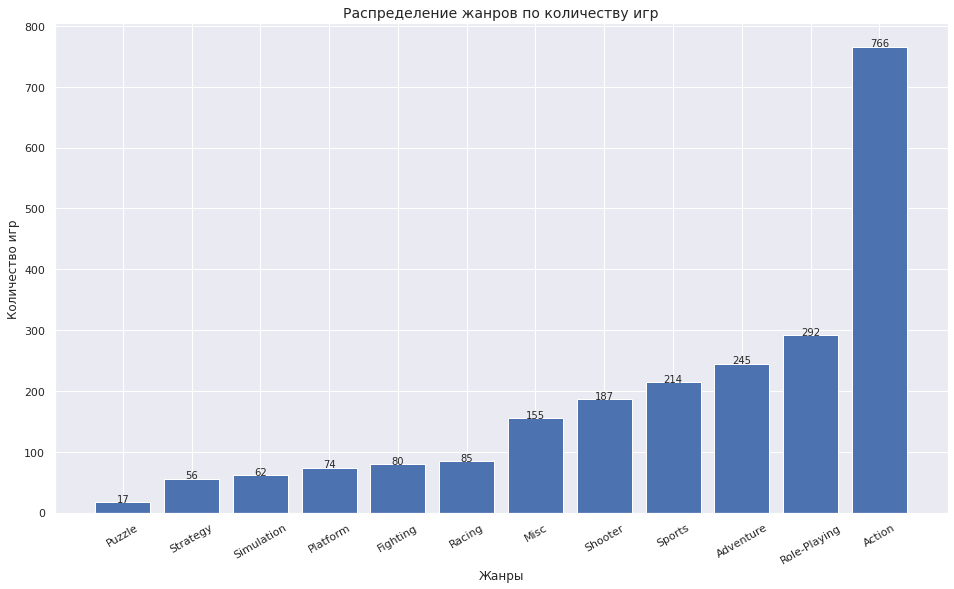

In [55]:
plt.figure(figsize=(16, 9))
plt.ylabel("Количество игр")
plt.xlabel("Жанры")
plt.xticks(rotation=30)

# Создание таблицы с подсчётом количества игр разного жанра
genre_count = data3.groupby('genre')['genre'].count().sort_values()

# Построение гистограммы
#ax = data2['genre'].hist(bins=23)
ax = plt.bar(genre_count.index, genre_count)
axes = plt.gca()

# Добавление числовых значений над столбцами
for patch in axes.patches:
    value = int(patch.get_height())
    if value > 0:
        axes.text(
            patch.get_x() + patch.get_width() / 2.,
            value,
            f"{value}",
            fontsize=10,
            ha='center',
        )

# Добавление заголовка
plt.title("Распределение жанров по количеству игр", fontsize=14)

plt.show()

По графику видно, что: 

- больше всего игр жанра *Action*,
- также весьма популярны *Role-Playing*, *Adventure*, *Shooter*, *Sports*, *Misc*
- жанры *Platform*, *Simulation*, *Puzzle*, *Fighting*, *Strategy*, *Racing* не обладают большой популярностью среди игроков

Из этого можно сделать вывод, что пользователям больше всего нравятся динамичные игры жанров *Action*, *Shooter*, *Sports*, *Role-Playing*, *Adventure*

Посмотрим, какие жанры самые прибыльные жанры в игровой индустрии

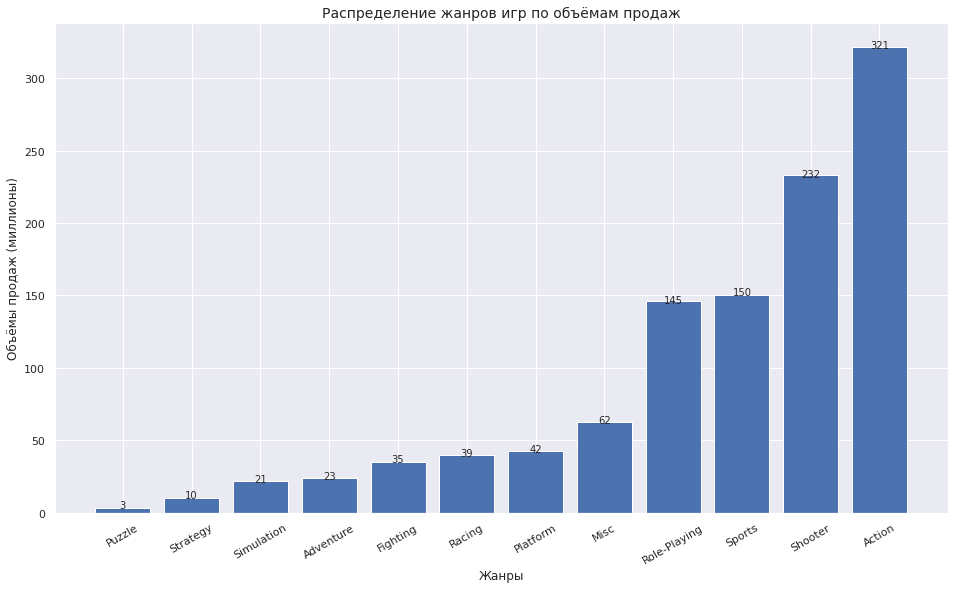

In [56]:
plt.figure(figsize=(16, 9))
plt.ylabel("Объёмы продаж (миллионы)")
plt.xlabel("Жанры")
plt.xticks(rotation=30)

# создание таблицы с продажами разных жанров
genre_sales = data3.groupby('genre')['overall_sales'].sum().sort_values()

# Построение гистограммы
ax = plt.bar(genre_sales.index, genre_sales)
axes = plt.gca()

# Добавление числовых значений над столбцами
for patch in axes.patches:
    value = int(patch.get_height())
    if value > 0:
        axes.text(
            patch.get_x() + patch.get_width() / 2.,
            value,
            f"{value}",
            fontsize=10,
            ha='center',
        )

# Добавление заголовка
plt.title("Распределение жанров игр по объёмам продаж", fontsize=14)

plt.show()

По графиуку видно, что:

- жанры *Shooter* и *Action* так же, как и в количестве игр, лидируют в продажах,
- *Sports*, *Role-Playing* имеют средний объём продаж,
- *Puzzle*, *Strategy*, *Adventure*, *Simulation*, *Fighting*, *Misc*, *Racing*, *Platform* имеют малый объём продаж.

Можно заметить, что *Shooter*-игры также немалый объём продаж(особенно, если сравнивать с общим количеством игр), что подтверждает наш прошлый вывод о том, что динамичные игры популярны среди пользователей.

Узнаем, насколько прибыльным является тот или иной жанр с помощью среднего значения(миллионов копий на жанр)

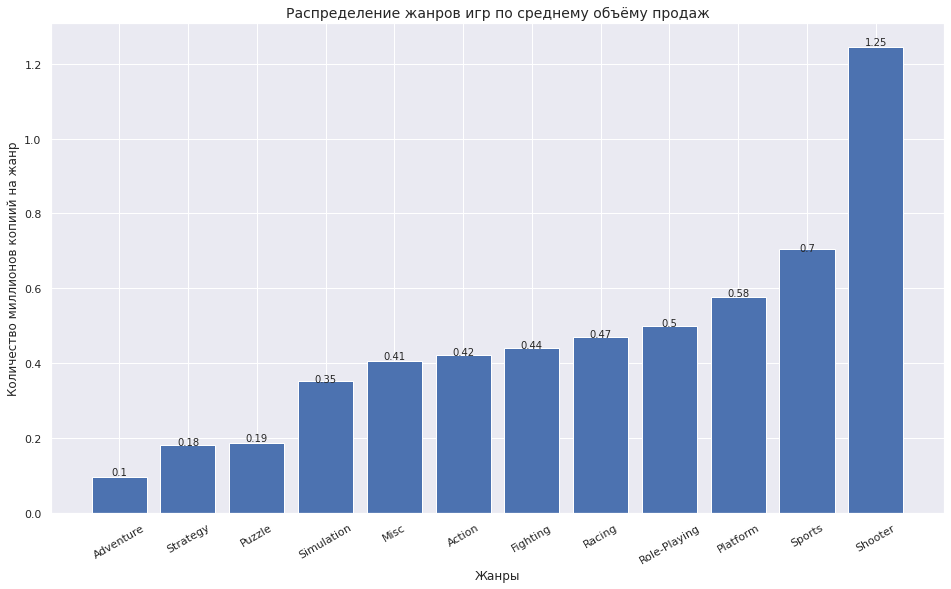

In [57]:
plt.figure(figsize=(16, 9))
plt.ylabel("Количество миллионов копиий на жанр")
plt.xlabel("Жанры")
plt.xticks(rotation=30)

# создание таблицы с продажами разных жанров
genre_sales_to_count = data3.groupby('genre')['overall_sales'].mean().sort_values()

# Построение гистограммы
ax = plt.bar(genre_sales_to_count.index, genre_sales_to_count)
axes = plt.gca()

# Добавление числовых значений над столбцами
for patch in axes.patches:
    value = float(round(patch.get_height(), 2))
    if value > 0:
        axes.text(
            patch.get_x() + patch.get_width() / 2.,
            value,
            f"{value}",
            fontsize=10,
            ha='center',
        )

# Добавление заголовка
plt.title("Распределение жанров игр по среднему объёму продаж", fontsize=14)

plt.show()

Этот график даёт нам понять, что *Shooter*-ы - самый прибыльный жанр, так как на каждую проданную игру этого типа приходится в среднем 1250 тысяч копий. 

Тенденция популярности динамичных игр остается.

**В ходе исследовательского анализа данныx было обнаружено, что**

- актуальным периодом для анализа является промежуток 2013 - 2016 года,
- потенциально прибыльные платформы для выпуска игры в 2017 году: PS4, XOne, 3DS,
- оценка критика хоть и слабо, но влияет на объёмы продаж, в то время как отзывы пользователей не влияют на количество проданных копий.
- *Shooter* - самый прибыльные жанры,
- самые популярные игры имеют динамичный жанр

<a id="shag4"></a> 
## Анализ пользователей каждого региона

### Определим, какие платформы самые популярные в разных регионах

Для начала, узнаем общий объём продаж игр в разных регионах

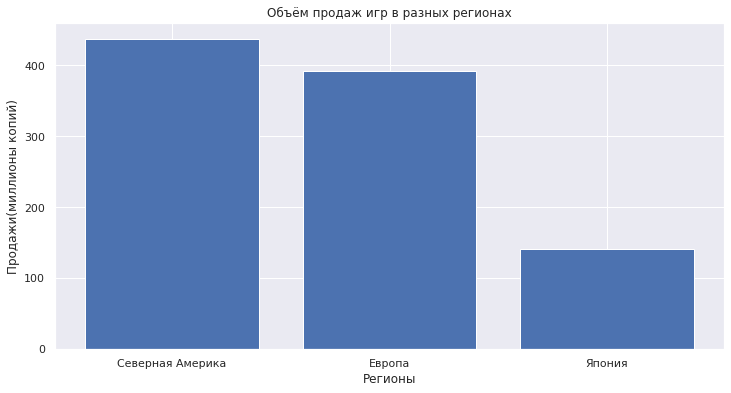

In [58]:
plt.figure(figsize=(12, 6))

plt.bar(['Северная Америка', 'Европа', 'Япония'],
        data3.agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum'}))

plt.title('Объём продаж игр в разных регионах')
    
plt.xlabel('Регионы')
plt.ylabel('Продажи(миллионы копий)')
plt.show();

Объёмы продаж игр из Северной Америки и Европы схожи, в то время как игры из Японии менее популярны

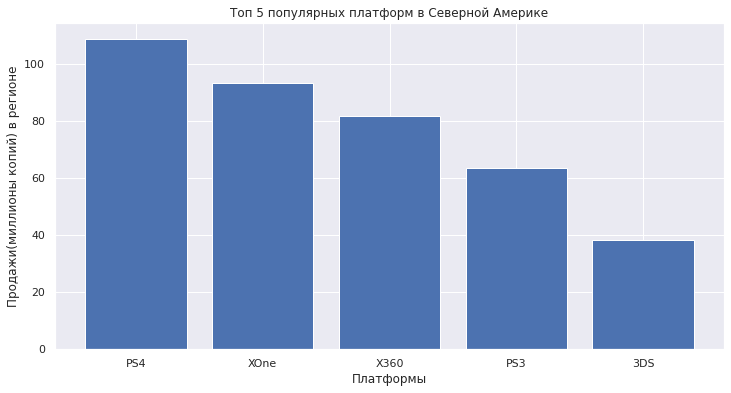

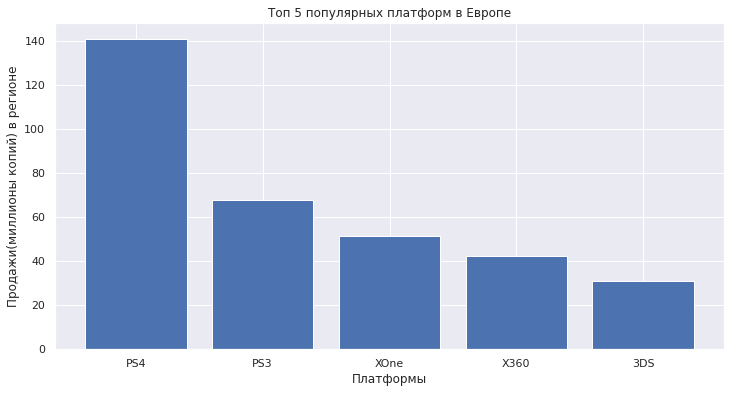

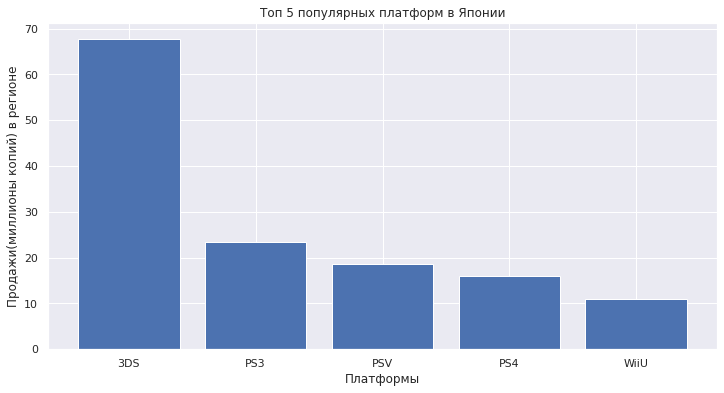

In [59]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    plt.figure(figsize=(12, 6))
    
    _data = data3.groupby('platform')[region].sum().sort_values(ascending=False)[:5]
    plt.bar(_data.index, _data)
    
    if region == 'na_sales':
        k = 'Северной Америке'
    elif region == 'eu_sales':
        k = 'Европе'
    else:
        k = 'Японии'
    plt.title(f'Топ 5 популярных платформ в {k}')
    
    plt.xlabel('Платформы')
    plt.ylabel('Продажи(миллионы копий) в регионе')
    plt.show();
    
    

По графикам можно сделать вывод, что:

- объём продаж игр на популярных платформах в Северной Америке немного превышает продажи в Европе и в 6 раза превышает продажи в Японии,
- популярные платформы в североамериканском и европейском регионах схожи (5 платформы из 5 одинаковы: *PS3*, *PS4*, *X360*, *XOne*, *3DS*), 
- японский рынок платформ отличается от остальных: в нём заметна популярность отечественных платформ, однако американские платформы также популярны

### Определим, какие жанры являются самыми популярными в разных регионах

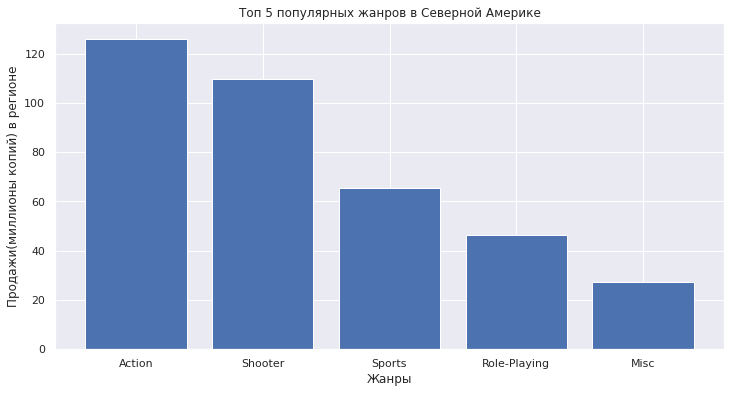

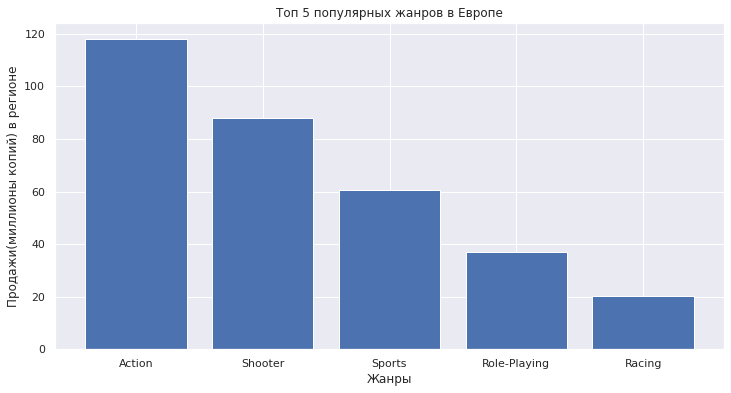

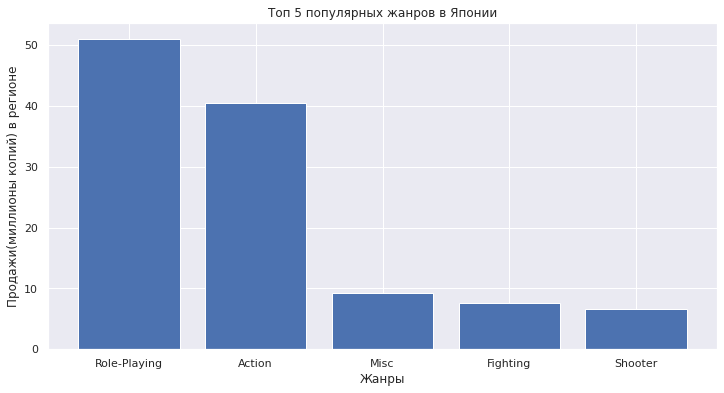

In [60]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    plt.figure(figsize=(12, 6))
    
    _data = data3.groupby('genre')[region].sum().sort_values(ascending=False)[:5]
    plt.bar(_data.index, _data)
    
    if region == 'na_sales':
        k = 'Северной Америке'
    elif region == 'eu_sales':
        k = 'Европе'
    else:
        k = 'Японии'
    plt.title(f'Топ 5 популярных жанров в {k}')
    
    plt.xlabel('Жанры')
    plt.ylabel('Продажи(миллионы копий) в регионе')
    plt.show();

Из этих данных можно сделать вывод, что:

- в североамериканском и европейском регионы популярны динамичные игры жанров *Action*, *Sports*, *Shooter*, *Role-Playing*, в то время как пользователи японских игр сосредоточены преимущественно на жанрах *Role-Playing* и *Action*, в то время как остальные жанры не особо популярны
- предпочтения в жанрах игр североамериканских и европейских пользователей практически(*Racing* и *Misc* популярны в разных регионах) одинаковы,
- японский рынок игр немного отличается о североамериканского и европейского: здесь большой популярность обладают игры жанра *Role-Playing*, однако другие динамичные жанры также присутствуют в рейтинге

### Проверим, влияет ли рейтинг ESRB на продажи в отдельном регионе

Для начала узнаем суммарные продажи игр разного рейтинга в мире

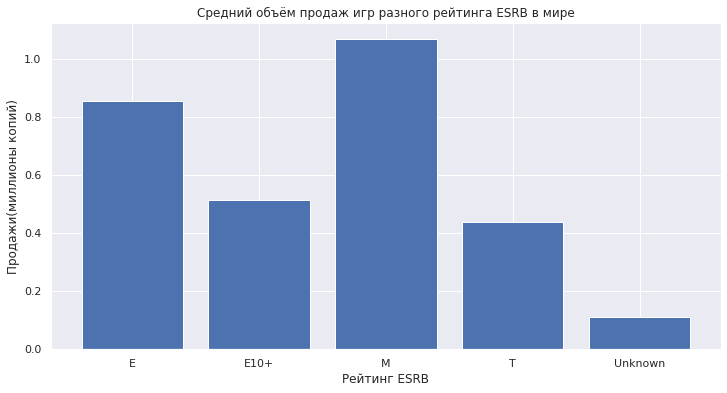

In [61]:
plt.figure(figsize=(12, 6))
    
_data = research_data.groupby('rating')['overall_sales'].mean()
plt.bar(_data.index, _data)
    
plt.title(f'Средний объём продаж игр разного рейтинга ESRB в мире')
    
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продажи(миллионы копий)')
plt.show();

In [62]:
research_data.groupby('rating').agg({'overall_sales': 'count'})

,overall_sales
rating,
E,196
E10+,163
M,323
T,260
Unknown,34


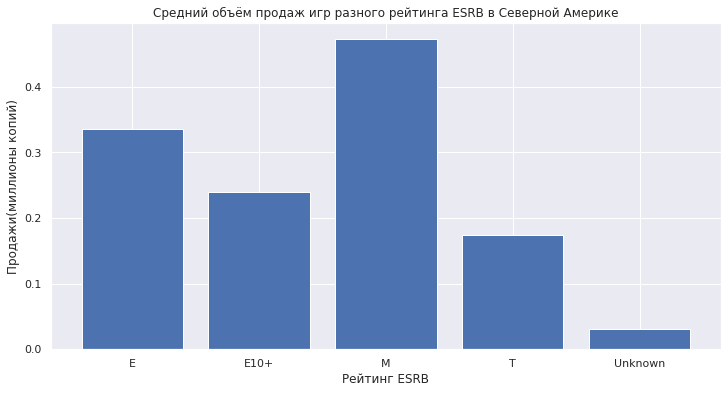

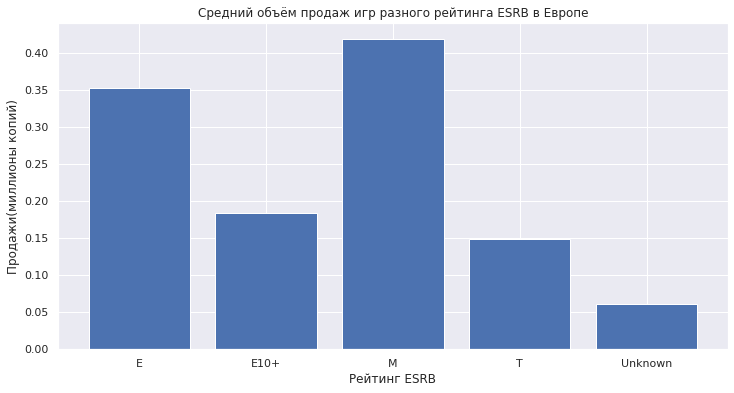

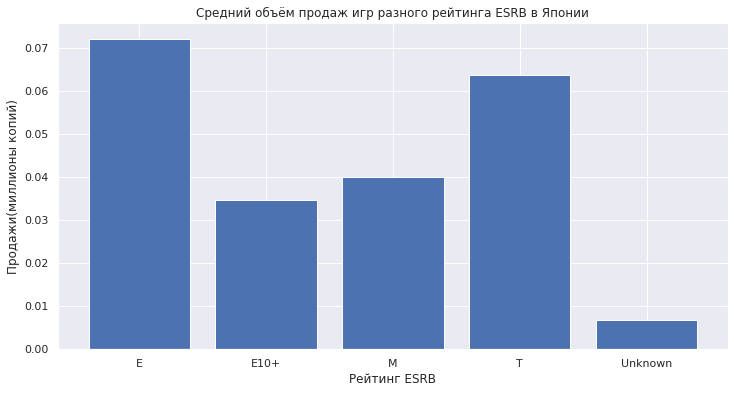

In [63]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    plt.figure(figsize=(12, 6))
    
    _data = research_data.groupby('rating')[region].mean() # сначала делал с медианой, но график не отрисовывается(в таблице нули)
    plt.bar(_data.index, _data)
    
    if region == 'na_sales':
        k = 'Северной Америке'
    elif region == 'eu_sales':
        k = 'Европе'
    else:
        k = 'Японии'
    plt.title(f'Средний объём продаж игр разного рейтинга ESRB в {k}')
    
    plt.xlabel('Рейтинг ESRB')
    plt.ylabel('Продажи(миллионы копий)')
    plt.show();

По графикам можно сделать вывод, что:

- игры с рейтингом M(17+) и E(всех возрастов) имеют самые большие продажи,
- в североамериканском и европейском регионах чётко выражена мировая ситуация продаж игр разного возрастного рейтинга, в то время как в Японии распределение другое: наиболее популярными являются игры с рейтингами T(подростки) и E(всех возрастов)

**В ходе анализа пользователей каждого региона было обнаружено, что:**

- пользователи игр из Северной Америки и Европы предпочитают игры на одинаковы платформах: *PS3*, *PS4*, *X360*, *XOne*, *3DS* - самые популярные платформы в североамериканском и европейском регионах,
- в североамериканском и европейском регионы популярны динамичные игры жанров *Action*, *Sports*, *Shooter*, *Role-Playing*, в то время как пользователи японских игр сосредоточены преимущественно на жанрах *Role-Playing* и *Action*, в то время как остальные жанры не особо популярны
- игры, сделанные в Европе или Северной Америке с рейтингом M(17+) и E(всех возрастов) имеют самые большие продажи, в то время как в Японии самые популярные игры имеют рейтинги T(подростки) и E(всех возрастов)

<a id="shag5"></a> 
## Проверка гипотез

Способ формулирования гипотез:

Нулевая гипотеза: представляет собой утверждение, которое предполагает отсутствие эффекта или различия между исследуемыми группами, поэтому я формулировал её, пердполагая, что среднее значение данных одинаково.

Альтернативная гипотеза: представляет собой противоположное утверждение относительно нулевой гипотезы, а значит её формулировка должна быть противоположна относительно нулевой гипотезы(как я и сделал)

###  Пользовательские рейтинги платформ Xbox One и PC

Сравним данные о рейтинге пользователей платформ Xbox One и PC.

In [64]:
research_data[research_data['platform'] == 'XOne']['user_score'].mean()

6.538181818181818

In [65]:
research_data[research_data['platform'] == 'PC']['user_score'].mean()

6.3020270270270276

Значения практически идентичны

Для более надёжной проверки гипотезы будем использовать t-тест(ttest_ind для проведения двухвыборочного t-теста Стьюдента), в котором:

*Нулевая гипотеза*: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

*Альтернативная гипотеза*: Средние пользовательские рейтинги платформ Xbox One и PC различны

In [66]:
alpha = 0.05

results = st.ttest_ind(
    research_data[research_data['platform'] == 'XOne']['user_score'],
    research_data[research_data['platform'] == 'PC']['user_score']
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.17306926618147322
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value больше заданного уровня значимости(alpha = 0.05), поэтому нулевую гипотезу отвергать не стоит. Есть основания говорить, что пользователи оценивают игры на Xbox One и PC одинаково.

### Пользовательские рейтинги жанров Action и Sports.

Сравним данные о рейтинге пользователей жанров *Action* и *Sports*.

In [67]:
research_data[research_data['genre'] == 'Action']['user_score'].mean()

6.9362459546925574

In [68]:
research_data[research_data['genre'] == 'Sports']['user_score'].mean()

5.665454545454545

Выходит так, что средний рейтинг игр жанра *Action* отличается от *Sports* на целый один пункт - значительное отличие

Для более надёжной проверки гипотезы будем использовать t-тест(ttest_ind для проведения двухвыборочного t-теста Стьюдента), в котором:

Нулевая гипотеза: Средние пользовательские рейтинги жанров *Action* и *Sports* одинаковые

Альтернативная гипотеза: Средние пользовательские рейтинги жанров *Action* и *Sports* различны

In [69]:
alpha = 0.05

results = st.ttest_ind(
    research_data[research_data['genre'] == 'Action']['user_score'],
    research_data[research_data['genre'] == 'Sports']['user_score']
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.684099430689953e-16
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости(alpha = 0.05), поэтому нулевую гипотезу следует отвергнуть. Есть основания говорить, что пользователи оценивают игры жанра *Action* и *Sports* по-разному.

**В ходе проверки гипотез мы выявили, что:**

- пользователи оценивают игры на Xbox One и PC одинаково,
- пользователи оценивают игры жанра Action и Sports по-разному

<a id="shag6"></a> 
## Общий вывод

**Обзор данных**:
- названия столбцов не соответсвуют стандарту,
- В столбцах *User_sales*, *Critic_Score*, *Rating* присутствуют пропущенные значения,
- параметр *User_score* имеет тип данных object вместо float,
- в столбцах *NA_sales*, *EU_sales*, *JP_sales*, *Other_sales* замечены аномальные значения,
- явные дубликаты в таблице отсутствуют.

**В результате предобработки данных были:**

- изменены названия столбцов(на более корректные),
- изменён тип данных столбца *user_score* c object на float,
- изменено значение рейтинга *K-A* на *E*,
- пропущенные значения рейтинга были заменены на *Unknown*,
- создан столбец *overall_sales*, который показывает общий объём продаж,
- cоздана таблица **data**, где были удалены столбцы *rating*, *user_score* , *ctitic_score* из-за слишком большого количества пропусков,а также удалены некоторые(менее 2%) данные, которые нельзя было восстановить,
- cоздана таблица **research_data** для будущей проверки гипотез, где остались все метрики, а также были удалены все недостающие значения
- удалены неявные дубликаты

**В ходе исследовательского анализа данныx было обнаружено, что**

- актуальным периодом для анализа является промежуток 2013 - 2016 года,
- потенциально прибыльные платформы для выпуска игры в 2017 году: PS4, XOne, 3DS,
- оценка критика хоть и слабо, но влияет на объёмы продаж, в то время как отзывы пользователей не влияют на количество проданных копий.
- *Shooter* - самый прибыльные жанры,
- самые популярные игры имеют динамичный жанр

**В ходе анализа пользователей каждого региона было обнаружено, что:**

- пользователи игр из Северной Америки и Европы предпочитают игры на одинаковы платформах: *PS3*, *PS4*, *X360*, *XOne*, *3DS* - самые популярные платформы в североамериканском и европейском регионах,
- в североамериканском и европейском регионы популярны динамичные игры жанров *Action*, *Sports*, *Shooter*, *Role-Playing*, в то время как пользователи японских игр сосредоточены преимущественно на жанрах *Role-Playing* и *Action*, в то время как остальные жанры не особо популярны
- игры, сделанные в Европе или Северной Америке с рейтингом M(17+) и E(всех возрастов) имеют самые большие продажи, в то время как в Японии самые популярные игры имеют рейтинги T(подростки) и E(всех возрастов)

**В ходе проверки гипотез мы выявили, что:**

- пользователи оценивают игры на Xbox One и PC одинаково,
- пользователи оценивают игры жанра Action и Sports по-разному

Таким образом, можно сделать вывод, что главными параметрами, определяющими успешность игры являются: оценка критиков, платформа, на которой будет выпущена игра, возрастной рейтинг(ESRB) игры, а также её жанр.

Данное исследование может помочь в процессе принятия решений интернет-магазина «Стримчик».